Here, we analyze within-host genetic diversity and evolutionary dynamics of H1N1pdm09virus samples. 

# Import libraries

In [1]:
from os.path import expanduser
from importlib.machinery import SourceFileLoader

import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D 
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr, mannwhitneyu
import numpy as np

import pandas as pd 
import re
import random
import os

# load custom flu and ngs libraries 
laeb_lib = expanduser("../python_lib") # folder where custom libraries are saved 
fc = SourceFileLoader('fc', "%s/flu_common.py"%(laeb_lib)).load_module()
ngs = SourceFileLoader('ngs', "%s/laeb_ngs_pipeline.py"%(laeb_lib)).load_module()

# Inputs 

In [2]:
# inputs 
# file path to data folder - fastq files to be analysed must be in {data folder}/raw
data_folder = './data' 
# reference fasta file name (should be placed in input_folder)
ref_fasta_fname = './input/H1N1pdm09_Cali09.fasta' 
# CSV file containing the CDR regions of each gene segment (numbering should be based on that of the given reference sequence)
cds_coords = "./input/CDS_H1N1pdm09_Cali09.csv"
nucpos_shift = "./input/CDS_shift_H1N1pdm09_Cali09.csv"
# file path to metadata file. 
meta_fname = './results/metadata_w_covbreadth.csv' 

# mapping options
threadnum = 4 # number of CPU threads for parallelization 
base_qual_threshold = 20 # minimum accepted base quality 
max_indel_prop = 0.05 # max tolerable proportion of indels wrt read length 
max_indel_abs = 10 # max tolerable absolute number of indels 

# variant calling options
Query_HAnum_subtype = 'absH1pdm' # query HA numbering subtype (i.e. numbering based on CDR HA protein )
HAnum_subtype = 'H3' # reporting HA numbering subtype
subtype_ant = 'H1ant'  # HA canonical antigenic site of interest 
min_cov = 50 # minimum coverage 
min_var_freq = 0
min_var_prop = 0.02 # minimum variant proportion 
err_tol = 0.01 # threshold to which variant called could result from base calling error 
min_breadth = 0.7 # min breadth of gene segment to be mapped for further analysis 

# Parameters and functions 

This cell perform several initialisation procedures, including: 
 - defining parameters needed by the pipeline (e.g. gene segment length, etc.) and initialise to get CDR regions of each protein.
 - defining dataframe for HA numbering conversion

In [3]:
# presets 
reffasta = ref_fasta_fname

# initialise
gene_to_proteinorf, influenza_gene_len, sorted_refnames, nucpos_shift = ngs.initialisation(cds_coords, reffasta, laeb_lib, nucpos_shift=nucpos_shift)
display (gene_to_proteinorf.head())

ha_numbering_conversion = pd.read_csv(expanduser('%s/HA_numbering_conversion.csv'%(laeb_lib)),
                                      na_values='-')
ha_numbering_conversion = ha_numbering_conversion.set_index(Query_HAnum_subtype)
display (ha_numbering_conversion.head())

codon_table = {
            'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
            'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
            'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
            'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
            'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',}
all_bases = ['A', 'T', 'G', 'C']


Initialising CDS coordinates...

Check translated protein sequences...
PB2 MERIKELRDLMSQSRTREILTKTTVDHMAIIKKYTSGRQEKNPALRMKWMMAMRYPITADKRIMDMIPERNEQGQTLWSKTNDAGSDRVMVSPLAVTWWNRNGPTTSTVHYPKVYKTYFEKVERLKHGTFGPVHFRNQVKIRRRVDTNPGHADLSAKEAQDVIMEVVFPNEVGARILTSESQLAITKEKKEELQDCKIAPLMVAYMLERELVRKTRFLPVAGGTGSVYIEVLHLTQGTCWEQMYTPGGEVRNDDVDQSLIIAARNIVRRAAVSADPLASLLEMCHSTQIGGVRMVDILRQNPTEEQAVDICKAAIGLRISSSFSFGGFTFKRTSGSSVKKEEEVLTGNLQTLKIRVHEGYEEFTMVGRRATAILRKATRRLIQLIVSGRDEQSIAEAIIVAMVFSQEDCMIKAVRGDLNFVNRANQRLNPMHQLLRHFQKDAKVLFQNWGIESIDNVMGMIGILPDMTPSTEMSLRGIRVSKMGVDEYSSTERVVVSIDRFLRVRDQRGNVLLSPEEVSETQGTEKLTITYSSSMMWEINGPESVLVNTYQWIIRNWEIVKIQWSQDPTMLYNKMEFEPFQSLVPKATRSRYSGFVRTLFQQMRDVLGTFDTVQIIKLLPFAAAPPEQSRMQFSSLTVNVRGSGLRILVRGNSPVFNYNKATKRLTVLGKDAGALTEDPDEGTSGVESAVLRGFLILGKEDKRYGPALSINELSNLAKGEKANVLIGQGDVVLVMKRKRDSSILTDSQTATKRIRMAIN*
PB1 MDVNPTLLFLKIPAQNAISTTFPYTGDPPYSHGTGTGYTMDTVNRTHQYSEKGKWTTNTETGAPQLNPIDGPLPEDNEPSGYAQTDCVLEAMAFLEESHPGIFENSCLETMEVVQQTRVDKLTQGRQTYDWTLNRNQPAATALANTIEVFRSNGLTANE

aa  frame
gene  nuc protein           
1-PB2 1   PB2       1      1
      2   PB2       1      2
      3   PB2       1      3
      4   PB2       2      1
      5   PB2       2      2

,H3,absH3,absH5,H1N1pdm,H5,H5c221,H1ant,H3ant,RBS
absH1pdm,,,,,,,,,
1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0
2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,0
3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,0
4.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,0
5.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,0


# Read metadata and variant calling files

In [4]:
# metadata 
## metadata must have 'sampid' header which is used as sample identifier 
meta_df = pd.read_csv('%s'%meta_fname)
meta_df = meta_df[meta_df["sampid"]!='3-12'] 
sorted_sampid = sorted(set(meta_df['sampid']))

meta_df = meta_df.set_index("sampid")
display (meta_df.head())

# vcf 
variant_call_df = pd.read_csv("./results/variant_call_MinCoV%i_MinProp%.2f_MinFreq%i_ErrTol%.2f.csv"%(min_cov, min_var_prop, min_var_freq, err_tol))
variant_call_df['protein'] = variant_call_df['protein'].fillna("NA")
variant_call_df = variant_call_df.set_index(["sampid", 'gene'])
display (variant_call_df.head())

,subject_id,enrolD,household,date,project,short_name,CT,age,sex,timepoint,...,ost_ed,ost_days,1-PB2,2-PB1,3-PA,4-HA,5-NP,6-NA,7-M,8-NS
sampid,,,,,,,,,,,,,,,,,,,,,
3-20,11-001,0,NaN,2009-11-13,Hanoi,11-001-d0,17.00,10.0,Female,2.0,...,11.0,1;11,1.000000,1.000000,1.000000,0.970606,1.000000,1.0,1.0,1.0
3-22,11-002,0,NaN,2009-11-17,Hanoi,11-002-d0,17.28,18.0,Female,4.0,...,13.0,3;13,1.000000,1.000000,1.000000,0.985303,1.000000,1.0,1.0,1.0
3-24,11-006,2,NaN,2009-12-11,Hanoi,11-006-d2,27.42,38.5,Male,4.0,...,9.0,1;9,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
3-1,11-1015,0,NaN,2009-10-22,Hanoi,11-1015-d0,25.00,39.4,Female,2.0,...,7.0,3;7,0.956140,0.967018,1.000000,1.000000,1.000000,1.0,1.0,1.0
3-3,11-1015,4,NaN,2009-10-27,Hanoi,11-1015-d4,33.09,39.4,Female,7.0,...,7.0,3;7,0.320175,0.098505,0.198047,0.764844,0.832999,1.0,1.0,1.0


nucpos nuc_var  nuc_prop  nuc_freq nuc_consensus  \
sampid gene                                                     
2-17   3-PA     204       A  0.153846        14             G   
       3-PA     204       A  0.153846        14             G   
       3-PA    1321       C  0.142857        12             A   
       3-PA    1848       A  0.130435        12             G   
       4-HA     249       A  0.044776         3             G   

             nuc_consensus_freq  nuc_coverage protein  aapos HA_num_type  \
sampid gene                                                                
2-17   3-PA                  77            91      PA     68         NaN   
       3-PA                  77            91    PA-X     68         NaN   
       3-PA                  72            84      PA    441         NaN   
       3-PA                  80            92      PA    616         NaN   
       4-HA                  64            67      HA     75          H3   

            aa_var   aa_prop  aa_freq expected_aa_consensus aa_consensus  \
sampid gene                                                                
2-17   3-PA      P  0.162791     14.0                     P            P   
       3-PA      P  0.162791     14.0                     P            P   
       3-PA      L  0.148148     12.0                     M            M   
       3-PA      S  0.134831     12.0                     S            S   
       4-HA      E  0.044776      3.0                     E            E   

             aa_consensus_freq  aa_coverage  codon_pos codon  nonsyn  
sampid gene                                                           
2-17   3-PA               72.0         86.0          3   CCA     0.0  
       3-PA               72.0         86.0          3   CCA     0.0  
       3-PA               69.0         81.0          1   CTG     1.0  
       3-PA               77.0         89.0          3   TCA     0.0  
       4-HA               64.0         67.0          3   GAA     0.0

# Plot cycle threshold (CT) values against time

/Users/alvin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


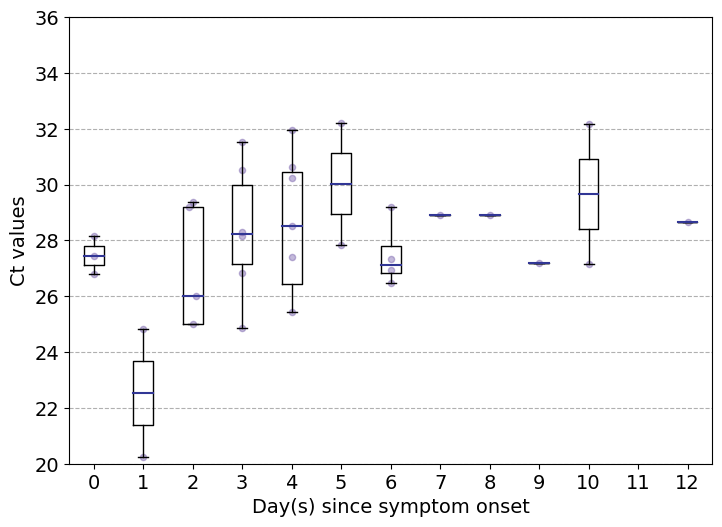

SpearmanrResult(correlation=0.3095312276171665, pvalue=0.07038337437132343)
(0.27429109261289875, 0.11081326360903594)


In [8]:
from scipy.stats import pearsonr, spearmanr

def get_jitter_xvals(data, center_x, width, bins=20):
    
    counts, edges = np.histogram(data, bins=bins)

    centres = (edges[:-1] + edges[1:]) / 2.
    yvals = centres.repeat(counts)

    max_offset = width / counts.max()
    offsets = np.hstack(list((np.arange(cc) - 0.5 * (cc - 1)) for cc in counts))
    
    return center_x + (offsets * max_offset)

# reset meta_df index  
try:
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index('timepoint').sort_index()

x_values = []
y_values = []

for tpx, timepoint in enumerate(sorted(set(meta_df.index.get_level_values(0)))): 
    # only analyse samples with information of time since symptom onset 
    if pd.isna(timepoint): 
        continue 
        
    if tpx > 0 and timepoint-prev_timepoint > 1: 
        for dummy_tp in range(int(prev_timepoint+1), int(timepoint)): 
            x_values.append(dummy_tp)
            y_values.append([])
            
    tp_meta_df = meta_df.loc[timepoint].copy()
    
    # filter samples where WG > min_breadth
    if isinstance(tp_meta_df, pd.Series):
        tp_meta_df = tp_meta_df.to_frame().T
    tp_meta_df = tp_meta_df[(tp_meta_df[sorted_refnames]>min_breadth).all(axis=1)]
    
    if len(tp_meta_df) == 0: 
        continue
    
    x_values.append(int(timepoint))
    y_values.append(list(tp_meta_df['CT']))
    
    prev_timepoint = timepoint
    
# plot boxplots
with plt.style.context('default'):
    fig, ax = plt.subplots(1, 1, figsize=(8.3, 5.8))
    ax.boxplot(y_values, positions=np.array(range(len(x_values))), sym='', widths=0.4, 
               medianprops=dict(linewidth=1.5, color='#313695'))

    # plot actual data as jitter 
    for idx, yval in enumerate(y_values):
        try: 
            ax.scatter(get_jitter_xvals(yval, center_x=idx,  width=0.3), 
                       yval, s=20, c='#6a51a3', alpha=.4)
        except:  
            ax.scatter([idx*2-0.4]*len(yval),
                       yval, s=20, c='#6a51a3', alpha=.4)

    # set x-ticks 
    ax.set_xticks(range(0, len(x_values)))
    ax.set_xticklabels(map(int, x_values))

    # set y-ticks 
    #ax.set_ylim((-1, 130))

    # grid lines 
    ax.grid(axis='y', ls='--', zorder=0)
    ax.set_axisbelow(True)

    # set title 
    #ax.set_title('CT vs day(s) since symptom onset', fontsize=12)

    # remove left and right spines 
    """ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)"""


    # tick fontsize
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Day(s) since symptom onset', fontsize=14)
    ax.set_ylabel('Ct values', fontsize=14)
    ax.set_ylim((20, 36))

    plt.savefig('./results/figures/CT_v_DaysSinceSymptomOnset.pdf', bbox_inches='tight', pad_inches=0.)
    plt.show()

# pearson R 
all_x_values = []
all_y_values = []
for xidx, xval in enumerate(x_values): 
    all_x_values += [xval]*len(y_values[xidx])
    all_y_values += y_values[xidx]
    
print (spearmanr(all_x_values, all_y_values))
print (pearsonr(all_x_values, all_y_values))

# Plot number of minority iSNVs against time/CT values 

'timepoint'

SpearmanrResult(correlation=-0.020587829713103516, pvalue=0.9065525129978488)

'ct'

SpearmanrResult(correlation=0.1977406286709128, pvalue=0.2093807182611637)

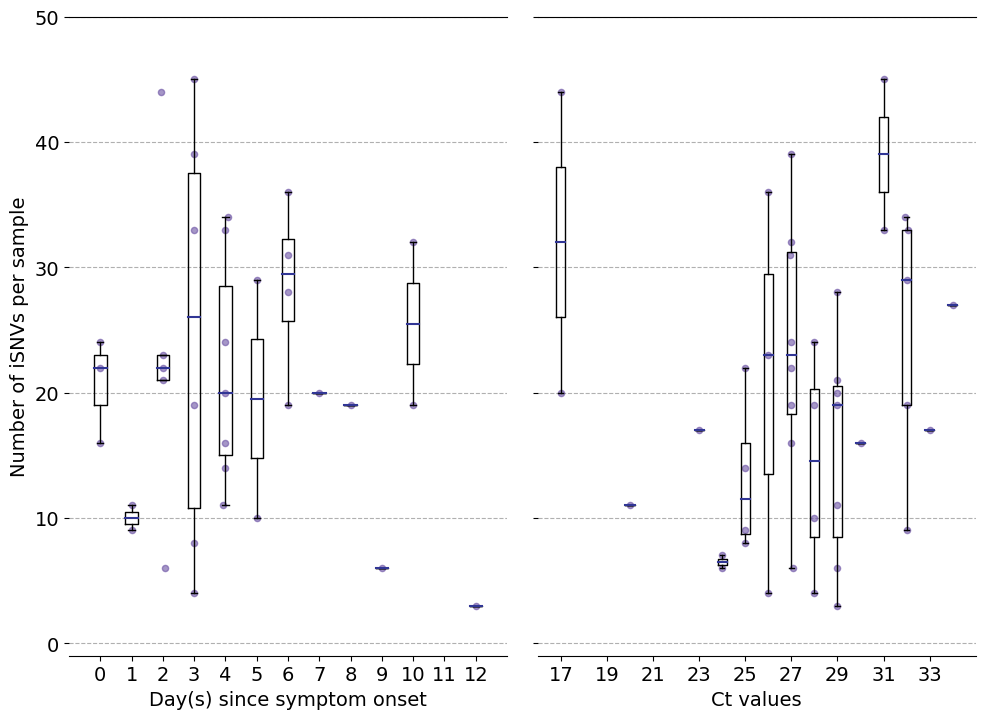

In [10]:
def get_jitter_xvals(data, center_x, width, bins=20):
    
    counts, edges = np.histogram(data, bins=bins)

    centres = (edges[:-1] + edges[1:]) / 2.
    yvals = centres.repeat(counts)

    max_offset = width / counts.max()
    offsets = np.hstack(list((np.arange(cc) - 0.5 * (cc - 1)) for cc in counts))
    
    return center_x + (offsets * max_offset)

try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 
variant_call_df = variant_call_df.set_index('sampid')

with plt.style.context('default'):
    fig, axes = plt.subplots(1, 2, figsize=(11.7, 8.3), sharey=True)

    for xidx, x_variable in enumerate(['timepoint', 'ct']): 

        ax = axes[xidx]

        # reset meta_df index  
        try:
            meta_df = meta_df.reset_index()
        except: 
            pass 
        meta_df = meta_df.set_index([x_variable, 'sampid']).sort_index()
        
        x_values = []
        iSNVdist_yvals = []

        for x_var in sorted(set(meta_df.index.get_level_values(0))): 

            # only analyse samples with information of time since symptom onset / ct value
            if pd.isna(x_var): 
                continue 

            tp_meta_df = meta_df.loc[x_var]

            # must satisfy min_breadth for all gene segments 
            tp_sampids = list(tp_meta_df[(tp_meta_df[sorted_refnames]>min_breadth).all(axis=1)].index)

            # no samples satisfying min_breadth 
            if len(tp_sampids) == 0:
                continue 

            # get number of iSNV across entire genome for each sampid 
            curr_x_var_iSNVdist = []
            for sampid in tp_sampids:

                try: 
                    sample_vcf = variant_call_df.loc[sampid].copy().reset_index()
                except: 
                    curr_x_var_iSNVdist.append(0)
                    continue 

                #sample_vcf = sample_vcf[sample_vcf['nuc_prop']>min_prop]

                # only consider nucleotide variants 
                sample_vcf = sample_vcf.drop_duplicates(['gene', 'nucpos', 'nuc_var'])

                sample_vcf = sample_vcf.drop_duplicates(subset=['gene', 'nucpos', 'nuc_var'])
                sample_vcf = sample_vcf[sample_vcf['nuc_prop']<.5]

                curr_x_var_iSNVdist.append(len(sample_vcf))
                #print (sampid, len(sample_vcf))

            iSNVdist_yvals.append (curr_x_var_iSNVdist)
            x_values.append(int(x_var))

        full_x_values = list(map(int, list(np.arange(np.min(x_values), np.max(x_values)+1, 1.))))
        plotted_x_values = [full_x_values.index(x_val) for x_val in x_values]

        # plot boxplots
        ax.boxplot(iSNVdist_yvals, positions=plotted_x_values, sym='', widths=0.4, 
                   medianprops=dict(linewidth=1.5, color='#313695'))

        # plot actual data as jitter 
        for idx, yval in enumerate(iSNVdist_yvals):
            try: 
                ax.scatter(get_jitter_xvals(yval, center_x=plotted_x_values[idx],  width=0.3), 
                           yval, s=20, c='#6a51a3', alpha=.6)
            except:  
                ax.scatter([idx*2-0.4]*len(yval), yval, s=20, c='#6a51a3', alpha=.6)

        # set x-ticks 
        ax.set_xlim((-1, len(full_x_values)))

        # set y-ticks 
        ax.set_ylim((-1, 50))

        # grid lines 
        ax.grid(axis='y', ls='--', zorder=0)
        ax.set_axisbelow(True)

        # tick fontsize
        ax.tick_params(axis='both', which='major', labelsize=14)
        if x_variable == 'ct': 
            ax.set_xlabel('Ct values', fontsize=14)
            x_ticks_idx = range(0, len(full_x_values), 2)
            ax.set_xticks(x_ticks_idx)
            ax.set_xticklabels(map(int, [full_x_values[idx] for idx in x_ticks_idx]))
        else: 
            ax.set_xlabel('Day(s) since symptom onset', fontsize=14)
            ax.set_xticks(range(0, len(full_x_values)))
            ax.set_xticklabels(map(int, full_x_values))

        if xidx == 0: 
            ax.set_ylabel('Number of iSNVs per sample', fontsize=14)

        # remove left and right spines 
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # pearson R 
        all_x_values = []
        all_y_values = []
        for xidx, xval in enumerate(x_values): 
            all_x_values += [xval]*len(iSNVdist_yvals[xidx])
            all_y_values += iSNVdist_yvals[xidx]

        display (x_variable, spearmanr(all_x_values, all_y_values))

    plt.subplots_adjust(wspace = 0.07, hspace = 0.2)
    plt.savefig('./results/figures/iSNVcounts_v_DaysSinceSymptomOnset_and_CT.pdf', 
                bbox_inches='tight', pad_inches=0.)
    plt.show()

# Compute nucleotide diversity ($\pi$)

In [11]:
def compute_pi(allele_array, L):
    N = allele_array.sum(axis=1)
    den = N*(N-1)
    num = den - (allele_array*(allele_array-1)).sum(axis=1)
    return (num/den).sum()/L

try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 

if os.path.isfile("./results/nucleotide_diversity_df.csv"): 
    nucleotide_diversity_df = pd.read_csv("./results/nucleotide_diversity_df.csv")
else: 
    print ("Computing nucleotide diversity...")
    nucleotide_diversity_df = []
    variant_call_df = variant_call_df.set_index(["sampid", "gene"])
    for (sampid, gene) in set(variant_call_df.index): 
        sample_gene_vcf = variant_call_df.loc[(sampid, gene)].copy()
        sample_gene_vcf = sample_gene_vcf.drop_duplicates(["nucpos", "nuc_var"])
        if len(sample_gene_vcf) > 1: 
            sample_gene_vcf = sample_gene_vcf.reset_index().set_index(['nucpos'])

            all_allele_counts = []
            for nucpos in set(sample_gene_vcf.index): 
                nucpos_sample_gene_vcf = sample_gene_vcf.loc[nucpos]
                if isinstance(nucpos_sample_gene_vcf, pd.Series):
                    nucpos_sample_gene_vcf = nucpos_sample_gene_vcf.to_frame().T

                nucpos_sample_gene_vcf = nucpos_sample_gene_vcf.set_index("nuc_var")

                allele_counts = []
                for idx, nuc_var in enumerate(nucpos_sample_gene_vcf.index):
                    # get consensus count 
                    if idx == 0:
                        allele_counts.append(nucpos_sample_gene_vcf.loc[nuc_var, "nuc_consensus_freq"])
                    # add individual variant
                    allele_counts.append(nucpos_sample_gene_vcf.loc[nuc_var, "nuc_freq"])
                all_allele_counts.append(allele_counts)

            arr_len = list(map(len, all_allele_counts))
            if len(set(arr_len)) > 1: 
                # make all arrays of the same dim
                max_len = max(arr_len)
                for idx, allele_counts in enumerate(all_allele_counts): 
                    if len(allele_counts) != max_len:
                        all_allele_counts[idx] += [0]*(max_len-len(allele_counts))

            pi = compute_pi(np.array(all_allele_counts), influenza_gene_len[gene])
            nucleotide_diversity_df.append({"sampid":sampid, "gene":gene, "pi":pi})

    nucleotide_diversity_df = pd.DataFrame.from_dict(nucleotide_diversity_df)
    nucleotide_diversity_df.to_csv("./results/nucleotide_diversity_df.csv", index=False)

nucleotide_diversity_df = nucleotide_diversity_df.set_index("sampid")
display (nucleotide_diversity_df.head())

,gene,pi
sampid,,
3-1,8-NS,0.000252
3-1,5-NP,0.000140
6-21,1-PB2,0.000350
3-15,1-PB2,0.000259
4-4,1-PB2,0.000204


'timepoint'

SpearmanrResult(correlation=0.016676770327955132, pvalue=0.9242477337361955)

'ct'

SpearmanrResult(correlation=0.23981102997770448, pvalue=0.1260985218500002)

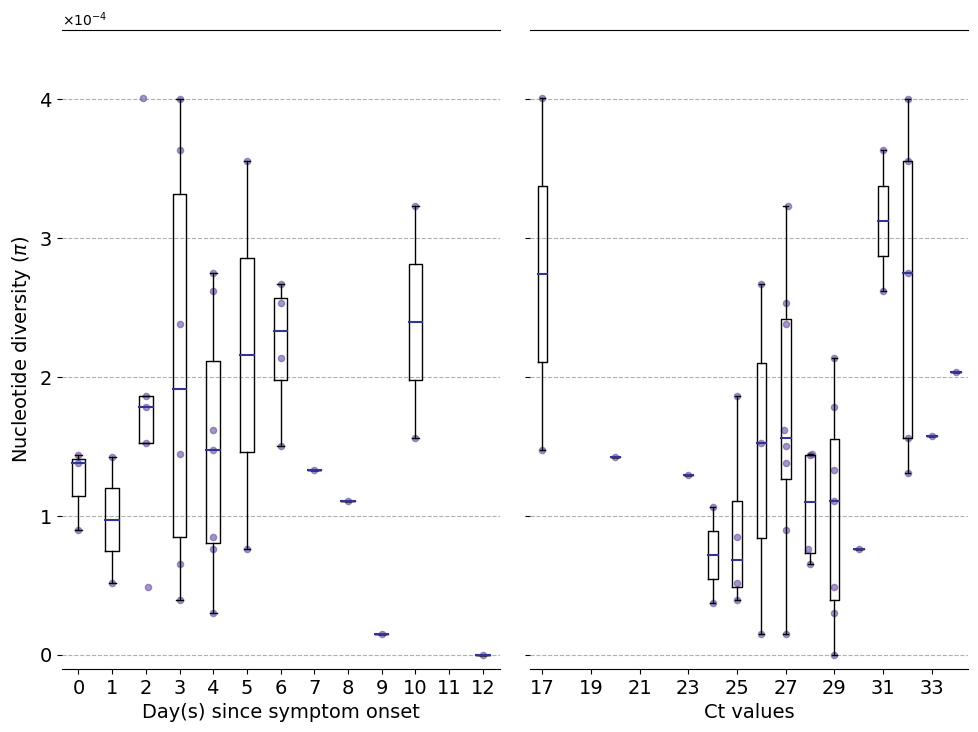

In [12]:
all_sample_wise_pi = []

with plt.style.context("default"):
    fig, axes = plt.subplots(1, 2, figsize=(11.7, 8.3), sharey=True)

    for xidx, x_variable in enumerate(['timepoint', 'ct']): 

        ax = axes[xidx]

        # reset meta_df index  
        try:
            meta_df = meta_df.reset_index()
        except: 
            pass 
        meta_df = meta_df.set_index([x_variable, 'sampid']).sort_index()

        y_values = []
        x_values = []

        for x_var in sorted(set(meta_df.index.get_level_values(0))): 
            if pd.isna(x_var): 
                continue

            tp_meta_df = meta_df.loc[x_var].copy()

            # get all samples where all segments > min_breadth 
            sampid_list = list(tp_meta_df[(tp_meta_df[sorted_refnames]>min_breadth).all(axis=1)].index)
            
            if len(sampid_list) == 0: 
                continue 

            x_values.append(x_var)

            # get pi dataframe - na values == pi=0
            curr_x_yvals = []
            for sampid in sampid_list: 
                try:
                    sampid_nucleotide_diversity_df = nucleotide_diversity_df.loc[sampid]
                except: 
                    curr_x_yvals.append(0.)
                    continue
                if isinstance(sampid_nucleotide_diversity_df, pd.Series): 
                    sampid_nucleotide_diversity_df = sampid_nucleotide_diversity_df.to_frame().T
                sampid_pi = sampid_nucleotide_diversity_df['pi'].to_numpy()
                coef = np.array([influenza_gene_len[gene]/sum(influenza_gene_len.values()) for gene in sampid_nucleotide_diversity_df['gene']])
                curr_x_yvals.append((sampid_pi*coef).sum())
            y_values.append(curr_x_yvals)
            if xidx == 0: 
                all_sample_wise_pi += curr_x_yvals
            
        full_x_values = list(map(int, list(np.arange(np.min(x_values), np.max(x_values)+1, 1.))))
        plotted_x_values = [full_x_values.index(int(x_val)) for x_val in x_values]

        # plot boxplots
        ax.boxplot(y_values, 
                   positions=plotted_x_values, 
                   sym='', widths=0.4, 
                   medianprops=dict(linewidth=1.5, color='#313695'))

        # plot actual data as jitter 
        for idx, yval in enumerate(y_values):
            try: 
                ax.scatter(get_jitter_xvals(yval, center_x=plotted_x_values[idx],  width=0.3), 
                           yval, s=20, c='#6a51a3', alpha=.6)
            except:  
                ax.scatter([idx*2-0.4]*len(yval),
                           yval, s=20, c='#6a51a3', alpha=.6)

        # set x-ticks 
        #ax.set_xticks(range(0, len(x_values)))
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)

        # set y-ticks 
        ax.set_ylim((-0.1e-4, 4.5e-4))

        # grid lines 
        ax.grid(axis='y', ls='--', zorder=0)
        ax.set_axisbelow(True)

        # tick fontsize
        ax.tick_params(axis='both', which='major', labelsize=14)
        if x_variable == 'ct': 
            ax.set_xlabel('Ct values', fontsize=14)
            x_ticks_idx = range(0, len(full_x_values), 2)
            ax.set_xticks(x_ticks_idx)
            ax.set_xticklabels(map(int, [full_x_values[idx] for idx in x_ticks_idx]))
        else: 
            ax.set_xlabel('Day(s) since symptom onset', fontsize=14)
            ax.set_xticks(range(0, len(full_x_values)))
            ax.set_xticklabels(map(int, full_x_values))

        if xidx == 0: 
            ax.set_ylabel('Nucleotide diversity $(\pi)$', fontsize=14)
            
        # remove left and right spines 
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # pearson R 
        all_x_values = []
        all_y_values = []
        for xidx, xval in enumerate(x_values): 
            all_x_values += [xval]*len(y_values[xidx])
            all_y_values += y_values[xidx]

        display (x_variable, spearmanr(all_x_values, all_y_values))

    plt.subplots_adjust(wspace = 0.07, hspace = 0.2)
    plt.savefig('./results/figures/pi_v_DaysSinceSymptomOnset_and_CT.pdf',
                bbox_inches='tight', pad_inches=0.)

    plt.show()
    
#print (all_sample_wise_pi)

# iSNV histogram

,Synonymous,Nonsynonymous,Stop
Frequency,,,
0.05,4.571429,9.071429,0.285714
0.10,1.921053,3.657895,0.105263
0.15,0.750000,1.333333,0.041667
0.20,0.350000,1.050000,0.000000
0.25,0.357143,1.000000,0.000000


1.939704830390422


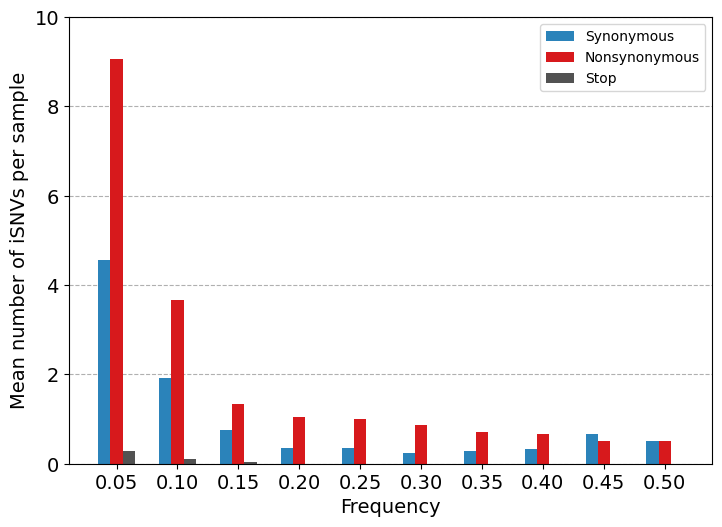

In [13]:
try: 
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index('sampid').sort_index()

try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 
variant_call_df = variant_call_df.set_index(['sampid', 'gene', 'nucpos', 'nuc_var']).sort_index()

with plt.style.context("default"):
    fig, ax = plt.subplots(1, 1, figsize=(8.3, 5.8))

    freq_to_count = {}
    bins = np.arange(0.05, 1.05, 0.05)

    for freq in bins: 
        freq_vcf = variant_call_df[(variant_call_df['nuc_prop']<freq)&(variant_call_df['nuc_prop']>=freq-0.05)].copy()

        # filter sampids where all gene segments fulfill min_breadth requirement 
        sampid_list = list(set(freq_vcf.index.get_level_values(0)))
        sampid_list = list(set(sampid_list)&set(meta_df.index))
        sampid_list = list(meta_df.loc[sampid_list][(meta_df.loc[sampid_list][sorted_refnames]>min_breadth).all(axis=1)].index)
        freq_vcf = freq_vcf[freq_vcf.index.get_level_values(0).isin(sampid_list)]

        if len(freq_vcf) == 0: 
            # do something
            continue 

        # separate into synonymous and nonsynonymous substitutions 
        nonsyn_count = 0
        syn_count = 0
        stop_count = 0

        for idx in freq_vcf.index: 
            # nucleotide mutation leads to either syn or nonsyn sub for any protein gene encodes
            if isinstance(freq_vcf.loc[idx], pd.Series) == True:
                if freq_vcf.loc[idx, 'nonsyn'] < 0: # stop codon 
                    stop_count += 1 
                elif freq_vcf.loc[idx, 'nonsyn'] > 0:
                    nonsyn_count += 1
                else: 
                    syn_count += 1
            else: 
                if len(freq_vcf.loc[idx]) == 1 or len(set(freq_vcf.loc[idx, 'nonsyn'])) == 1: 
                    if freq_vcf.loc[idx, 'nonsyn'].iloc[0] < 0: # stop codon 
                        stop_count += 1 
                    elif freq_vcf.loc[idx, 'nonsyn'].iloc[0] > 0: 
                        nonsyn_count += 1
                    else: 
                        syn_count += 1
                else: 
                    # for each protein that the gene encodes 
                    idx_freq_vcf = freq_vcf.loc[idx]
                    for protein in set(idx_freq_vcf['protein']): 
                        protein_idx_freq_vcf = idx_freq_vcf[idx_freq_vcf['protein']==protein]

                        # nucleotide mutation leads to either syn or nonsyn sub for protein 
                        if len(protein_idx_freq_vcf) == 1: 
                            if freq_vcf.loc[idx, 'nonsyn'].iloc[0] < 0: 
                                stop_count += 1
                            elif freq_vcf.loc[idx, 'nonsyn'].iloc[0] > 0: 
                                nonsyn_count += 1
                            else: 
                                syn_count += 1
                        else: 
                            # nucleotide mutation leads to both syn and nonsyn sub
                            #display (protein_idx_freq_vcf)
                            # continue if not enough aa_consensus 
                            if protein_idx_freq_vcf['aa_coverage'].iloc[0]<min_cov: 
                                continue 
                            else: 
                                nonsyn_prop = protein_idx_freq_vcf[protein_idx_freq_vcf['nonsyn']>0]['aa_prop'].sum()
                                syn_prop = protein_idx_freq_vcf[protein_idx_freq_vcf['nonsyn']<1.]['aa_prop'].sum()
                                #! -- need to fix this -- #
                            continue 

        total_num_of_samples = len(set(freq_vcf.index.get_level_values(0)))

        rounded_freq = np.around(freq, 2)
        if rounded_freq > 0.5: 
            continue 
        try:
            freq_to_count[rounded_freq]["Synonymous"] += syn_count/total_num_of_samples
            freq_to_count[rounded_freq]["Nonsynonymous"] += nonsyn_count/total_num_of_samples
            freq_to_count[rounded_freq]["Stop"] += stop_count/total_num_of_samples
        except: 
            freq_to_count[rounded_freq] = {"Synonymous":syn_count/total_num_of_samples, 
                                           "Nonsynonymous":nonsyn_count/total_num_of_samples, 
                                           "Stop":stop_count/total_num_of_samples}

    overall_iSNVfreq_distributions = []
    for freq, count_dict in freq_to_count.items(): 
        row = {"Frequency":freq}
        for k, v in count_dict.items():
            row[k] = v
        overall_iSNVfreq_distributions.append(row)

    overall_iSNVfreq_distributions = pd.DataFrame.from_dict(overall_iSNVfreq_distributions)
    overall_iSNVfreq_distributions = overall_iSNVfreq_distributions.set_index("Frequency")
    display (overall_iSNVfreq_distributions.head())
    print (overall_iSNVfreq_distributions['Nonsynonymous'].sum()/overall_iSNVfreq_distributions['Synonymous'].sum())

    #overall_iSNVfreq_distributions.plot.bar(ax=ax, fontsize=12, color=['#2b83ba', '#d7191c'], )

    labels = list(overall_iSNVfreq_distributions.index)

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    ax.bar(x - width, overall_iSNVfreq_distributions['Synonymous'], width, label='Synonymous', color="#2b83ba")
    ax.bar(x, overall_iSNVfreq_distributions['Nonsynonymous'], width, label='Nonsynonymous', color="#d7191c")
    ax.bar(x + width, overall_iSNVfreq_distributions['Stop'], width, label='Stop', color="#525252")

    # grid lines 
    ax.grid(axis='y', ls='--', zorder=0)
    ax.set_axisbelow(True)

    # labels
    ax.set_xlabel("Frequency", fontsize=14)
    ax.set_ylabel("Mean number of iSNVs per sample", fontsize=14)

    ax.set_xticks(x)
    ax.set_xticklabels(["%.2f"%(l) for l in labels])
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_ylim(0, 10)
    ax.legend()

    # y-axis label 
    plt.savefig('./results/figures/syn_nonsyn_histogram_overall.pdf',
                bbox_inches='tight', pad_inches=0.)
    plt.show()

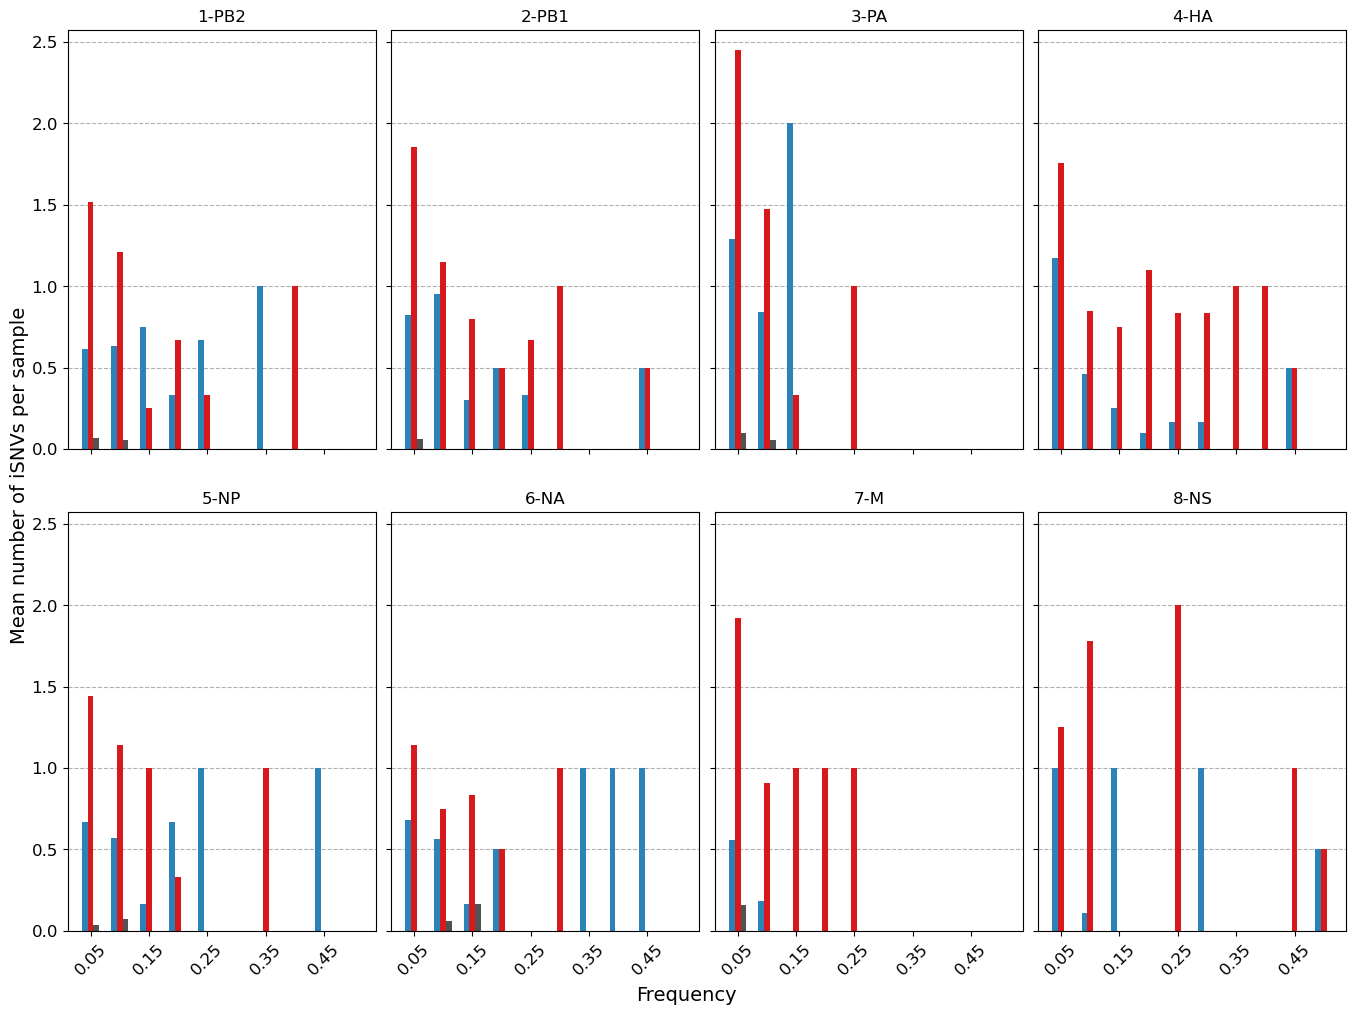

,NS,S,Stop,dNdS
gene,,,,
1-PB2,4.976655,3.994482,0.117148,1.245882
2-PB1,6.469608,3.406863,0.058824,1.898993
3-PA,5.258630,4.132428,0.149406,1.272528
4-HA,8.621441,2.817286,0.000000,3.060194
5-NP,4.920635,4.071429,0.108466,1.208577
6-NA,4.226190,4.907738,0.229167,0.861128
7-M,5.829091,0.741818,0.160000,7.857843
8-NS,6.527778,3.611111,0.000000,1.807692


In [14]:
try: 
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index('sampid').sort_index()

try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 
variant_call_df = variant_call_df.set_index(['sampid', 'gene', 'nucpos', 'nuc_var']).sort_index()

with plt.style.context('default'):
    fig, axes = plt.subplots(2, 4, figsize=(16.5, 11.7), sharex=True, sharey=True)
    gene_dNdS = []
    for gidx, gene in enumerate(sorted_refnames):
        # get ax coordinates
        plot_row = 0 if gidx < 4 else 1 
        plot_col = gidx%4
        #print (plot_row, plot_col)
        ax = axes[(plot_row, plot_col)]
        
        # filter vcf for gene 
        gene_vcf = variant_call_df.xs(gene, level=1)
        
        freq_to_count = {}
        bins = np.arange(0.05, 0.55, 0.05)

        for freq in bins: 
            freq_gene_vcf = gene_vcf[(gene_vcf['nuc_prop']<freq)&(gene_vcf['nuc_prop']>=freq-0.05)].copy()

            # filter sampids where all gene segments fulfill min_breadth requirement 
            sampid_list = list(set(freq_gene_vcf.index.get_level_values(0)))
            sampid_list = list(set(sampid_list)&set(meta_df.index))
            sampid_list = list(meta_df.loc[sampid_list][(meta_df.loc[sampid_list][sorted_refnames]>min_breadth).all(axis=1)].index)
            freq_gene_vcf = freq_gene_vcf[freq_gene_vcf.index.get_level_values(0).isin(sampid_list)]

            if len(freq_gene_vcf) == 0: 
                # do something
                continue 

            # separate into synonymous and nonsynonymous substitutions 
            nonsyn_count = 0
            syn_count = 0
            stop_count = 0

            for idx in freq_gene_vcf.index: 
                # nucleotide mutation leads to either syn or nonsyn sub for any protein gene encodes
                if isinstance(freq_gene_vcf.loc[idx], pd.Series) == True:
                    if freq_gene_vcf.loc[idx, 'nonsyn'] < 0:
                        stop_count += 1
                    elif freq_gene_vcf.loc[idx, 'nonsyn'] > 0:
                        nonsyn_count += 1
                    else: 
                        syn_count += 1
                else: 
                    if len(freq_gene_vcf.loc[idx]) == 1 or len(set(freq_gene_vcf.loc[idx, 'nonsyn'])) == 1: 
                        if freq_gene_vcf.loc[idx, 'nonsyn'].iloc[0] < 0: 
                            stop_count += 1
                        elif freq_gene_vcf.loc[idx, 'nonsyn'].iloc[0] > 0: 
                            nonsyn_count += 1
                        else: 
                            syn_count += 1
                    else: 
                        # for each protein that the gene encodes 
                        idx_freq_gene_vcf = freq_gene_vcf.loc[idx]
                        for protein in set(idx_freq_gene_vcf['protein']): 
                            protein_idx_freq_gene_vcf = idx_freq_gene_vcf[idx_freq_gene_vcf['protein']==protein]

                            # nucleotide mutation leads to either syn or nonsyn sub for protein 
                            if len(protein_idx_freq_gene_vcf) == 1: 
                                if freq_gene_vcf.loc[idx, 'nonsyn'].iloc[0] < 0: 
                                    stop_count += 1
                                elif freq_gene_vcf.loc[idx, 'nonsyn'].iloc[0] > 0: 
                                    nonsyn_count += 1
                                else: 
                                    syn_count += 1
                            else: 
                                # nucleotide mutation leads to both syn and nonsyn sub
                                #display (protein_idx_freq_gene_vcf)
                                # continue if not enough aa_consensus 
                                if protein_idx_freq_gene_vcf['aa_coverage'].iloc[0]<min_cov: 
                                    continue 
                                else: 
                                    nonsyn_prop = protein_idx_freq_gene_vcf[protein_idx_freq_gene_vcf['nonsyn']>0]['aa_prop'].sum()
                                    syn_prop = protein_idx_freq_gene_vcf[protein_idx_freq_gene_vcf['nonsyn']<1.]['aa_prop'].sum()
                                    #! -- need to fix this -- #
                                continue 

            total_num_of_samples = len(set(freq_gene_vcf.index.get_level_values(0)))

            rounded_freq = np.around(freq, 2)
            if rounded_freq > 0.5: 
                continue 
            try:
                freq_to_count[rounded_freq]["Synonymous"] += syn_count/total_num_of_samples
                freq_to_count[rounded_freq]["Nonsynonymous"] += nonsyn_count/total_num_of_samples
                freq_to_count[rounded_freq]["Stop"] += stop_count/total_num_of_samples
            except: 
                freq_to_count[rounded_freq] = {"Synonymous":syn_count/total_num_of_samples, 
                                               "Nonsynonymous":nonsyn_count/total_num_of_samples, 
                                               "Stop":stop_count/total_num_of_samples}

        gene_iSNVfreq_distributions = []
        for freq, count_dict in freq_to_count.items(): 
            row = {"Frequency":freq}
            for k, v in count_dict.items():
                row[k] = v
            gene_iSNVfreq_distributions.append(row)

        gene_iSNVfreq_distributions = pd.DataFrame.from_dict(gene_iSNVfreq_distributions)
        gene_iSNVfreq_distributions = gene_iSNVfreq_distributions.set_index("Frequency")
        #display (gene_iSNVfreq_distributions.head())
        
        gene_dNdS.append({"gene":gene,
                          "NS":gene_iSNVfreq_distributions['Nonsynonymous'].sum(), 'S':gene_iSNVfreq_distributions['Synonymous'].sum(), 
                          "Stop":gene_iSNVfreq_distributions['Stop'].sum(), 
                          "dNdS":gene_iSNVfreq_distributions['Nonsynonymous'].sum()/gene_iSNVfreq_distributions['Synonymous'].sum()})

        labels = list(gene_iSNVfreq_distributions.index)
        x = [] # the label locations
        lidx = 0 
        for bidx, b in enumerate(bins): 
            if lidx >= len(labels): 
                break 
            if np.isclose(labels[lidx], b): 
                x.append(bidx)
                lidx += 1
        x = np.array(x)
        width = 0.2  # the width of the bars
        
        ax.bar(x - width, gene_iSNVfreq_distributions['Synonymous'], width, label='Synonymous', color="#2b83ba")
        ax.bar(x, gene_iSNVfreq_distributions['Nonsynonymous'], width, label='Nonsynonymous', color="#d7191c")
        ax.bar(x + width, gene_iSNVfreq_distributions['Stop'], width, label='Stop', color="#525252")

        # grid lines 
        ax.grid(axis='y', ls='--', zorder=0)
        ax.set_axisbelow(True)

        # labels
        ax.set_title(gene)
        
        ax.set_xticks([bidx for bidx, b in enumerate(bins) if bidx%2==0])
        ax.set_xticklabels(["%.2f"%(b) for bidx, b in enumerate(bins) if bidx%2==0], rotation=45)
        
        ax.tick_params(axis='both', which='both', labelsize=12)
    
    # y-axis label 
    fig.text(0.09, 0.5, 'Mean number of iSNVs per sample', va='center', 
             fontsize=14, rotation=90)
    # x-axis label
    fig.text(0.5, 0.05, "Frequency", ha='center', 
             fontsize=14)
    
    # y-axis label 
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    plt.savefig('./results/figures/syn_nonsyn_histogram_gene.pdf',
                bbox_inches='tight', pad_inches=0.)
    plt.show()
    
    gene_dNdS = pd.DataFrame.from_dict(gene_dNdS).set_index("gene").sort_index()
    gene_dNdS.to_csv("./results/gene_dNdS.csv")
    display (gene_dNdS)

# Compare iSNVs between HA antigenic and non-antigenic sites

0


MannwhitneyuResult(statistic=58.0, pvalue=0.14036885891167028)

0.05084745762711865 0.05011508683825068 0.0701998482165444
0.04206103494029191 0.030553824583268427 0.06941718254567417
1


MannwhitneyuResult(statistic=256.0, pvalue=0.34195802252241253)

0.03614457831325301 0.035294117647058816 0.05263157894736842
0.04608294930875576 0.034937294240009624 0.15609103078982597


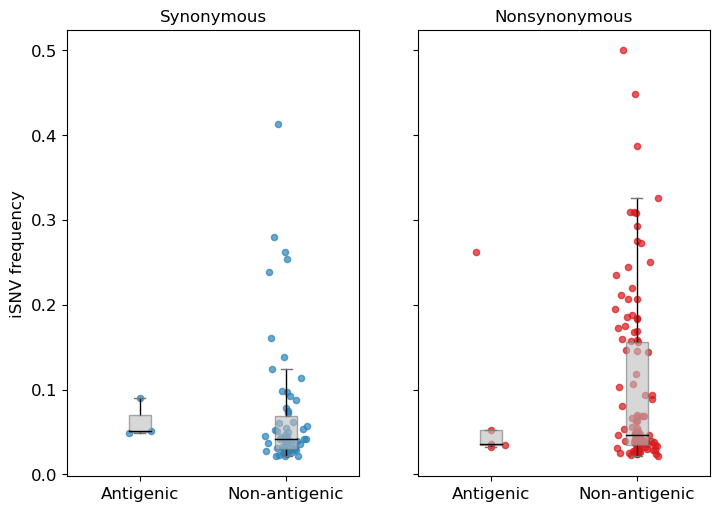

In [15]:
# compare HA antigenic (1) and non-antigenic (0) sites 
y_values = {0:[[], []], 1:[[], []]}

try: 
    variant_call_df = variant_call_df.reset_index()
except:
    pass 

variant_call_df = variant_call_df.set_index(["sampid", "gene", "nucpos"])

for nonsyn_bool in range(2): 
    ha_vcf = variant_call_df.xs("4-HA", level=1)
    ha_vcf = ha_vcf[ha_vcf['nonsyn']==nonsyn_bool]
    
    for idx in ha_vcf.index: 
        idx_ha_vcf = ha_vcf.loc[idx]

        if isinstance(idx_ha_vcf, pd.Series): 
            idx_ha_vcf = idx_ha_vcf.to_frame().T

        sampid, nucpos = idx 
        
        # non-antigenic site 
        try:
            gene_to_proteinorf.loc[("4-HA", nucpos)]
        except: 
            continue 
        if pd.isna(ha_numbering_conversion.loc[gene_to_proteinorf.loc[("4-HA", nucpos), 'aa'].iloc[0], subtype_ant]):
            y_values[nonsyn_bool][1].append(idx_ha_vcf['nuc_prop'].iloc[0])
        # antigenic site 
        else:
            """if nonsyn_bool == 0: 
                print (ha_numbering_conversion.loc[gene_to_proteinorf.loc[("4-HA", nucpos), 'aa'].iloc[0], subtype_ant])
                print (nucpos)"""
            y_values[nonsyn_bool][0].append(idx_ha_vcf['nuc_prop'].iloc[0])

with plt.style.context("default"):
    fig, axes = plt.subplots(1, 2, figsize=(8.3, 5.8), sharey=True)
    color_scheme=['#2b83ba', '#d7191c']

    for nonsyn_bool in range(2): 
        print (nonsyn_bool)
        display (mannwhitneyu(y_values[nonsyn_bool][0], y_values[nonsyn_bool][1]))
        med_x = np.median(y_values[nonsyn_bool][0])
        print (med_x, np.quantile(y_values[nonsyn_bool][0], 0.25), np.quantile(y_values[nonsyn_bool][0], 0.75))    

        med_x = np.median(y_values[nonsyn_bool][1])
        print (med_x, np.quantile(y_values[nonsyn_bool][1], 0.25), np.quantile(y_values[nonsyn_bool][1], 0.75))    

        ax = axes[nonsyn_bool]

        ax.boxplot(y_values[nonsyn_bool], patch_artist=True,
                   boxprops=dict(facecolor="#bdbdbd", color="#737373", alpha=0.6),
                   capprops=dict(color="#737373"),
                   whiskerprops=dict(color="#000000"),
                   flierprops=dict(markeredgecolor="#bdbdbd", markerfacecolor="#bdbdbd", marker='.', alpha=0.),
                   medianprops=dict(color="#000000"),)

        # plot actual data as jitter 
        for idx, yval in enumerate(y_values[nonsyn_bool]):
            idx += 1
            try: 
                ax.scatter(get_jitter_xvals(yval, center_x=idx,  width=0.3), 
                           yval, s=20, c=color_scheme[nonsyn_bool], alpha=.7)
            except:  
                ax.scatter([idx*2-0.4]*len(yval),
                           yval, s=20, c=color_scheme[nonsyn_bool], alpha=.7)

        ax.tick_params(axis='both', which='major', labelsize=12)
        # xtick labels
        ax.set_xticklabels(["Antigenic", "Non-antigenic"])

        if nonsyn_bool == 0: 
            ax.set_title("Synonymous", fontsize=12)
        else: 
            ax.set_title("Nonsynonymous", fontsize=12)

    # ytick
    #ax.set_ylim((0., 0.1))
    axes[0].set_ylabel("iSNV frequency", fontsize=12)

    plt.savefig('./results/figures/HA_ant_compare.pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

# Polymorphic nonsynonymous sites across individuals

subject_num               mean_prop
gene  nonsyn nucpos                                     
1-PB2 -1.0   542               1   [0.08914728682170542]
             1147              1  [0.026104417670682733]
             1178              1   [0.02325581395348837]
       0.0   51                1  [0.029810298102981032]
             63                1  [0.020715630885122408]

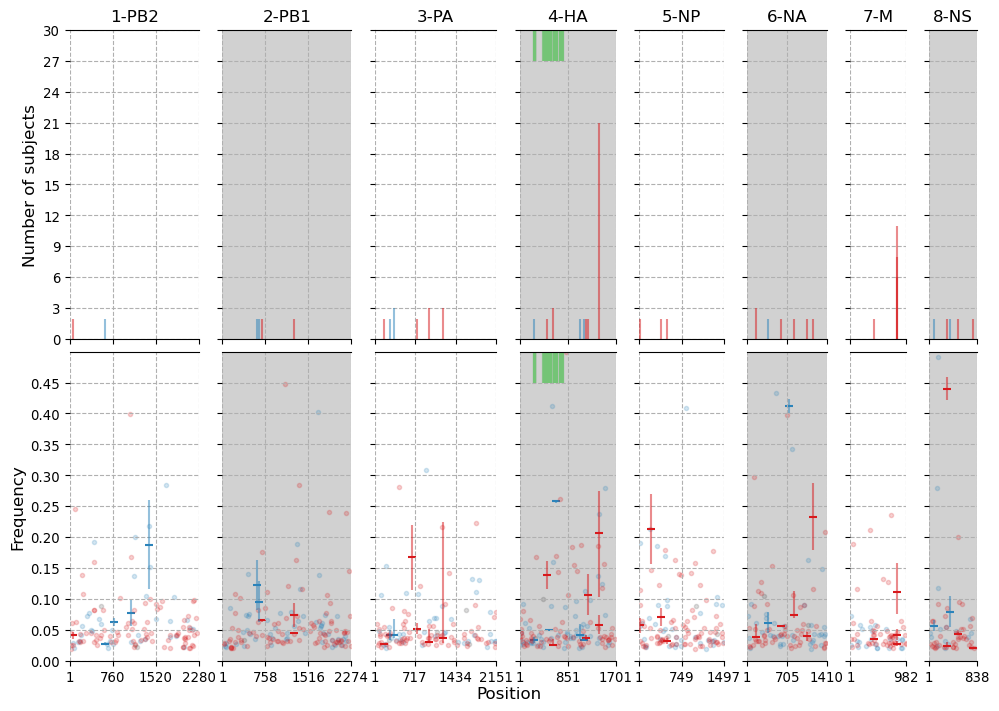

In [16]:
subject_nuc_mutation_dict = {}
for sampid in meta_df.index: 
    # subject_id 
    subject_id = meta_df.loc[sampid, 'subject_id']

    # filter for gene segments > min_breadth 
    genes_to_analyse = meta_df.loc[sampid][sorted_refnames]
    genes_to_analyse = list(genes_to_analyse[genes_to_analyse>min_breadth].index)

    """# here, we accept any samples for the gene segment > min_breadth 
    if len(genes_to_analyse) < 8: 
        continue """

    for gene in genes_to_analyse: 
        try: 
            gene_vcf = variant_call_df.loc[(sampid, gene)].copy()
        except: 
            # no mutations found in gene 
            continue 

        for nucpos in set(gene_vcf.index):
            if isinstance(gene_vcf.loc[nucpos, 'nonsyn'], pd.Series): 
                nucpos_gene_vcf = gene_vcf.loc[nucpos] 
                if len(nucpos_gene_vcf) == 0: # stop codons are ignored 
                    continue
                nonsyn = max(nucpos_gene_vcf['nonsyn'])
                nuc_prop = nucpos_gene_vcf['nuc_prop'].iloc[0]
            else: 
                nonsyn = gene_vcf.loc[nucpos, 'nonsyn']
                nuc_prop = gene_vcf.loc[nucpos, 'nuc_prop']

            try:
                subject_nuc_mutation_dict[gene][nonsyn][nucpos].append((subject_id, nuc_prop))
            except: 
                try: 
                    subject_nuc_mutation_dict[gene][nonsyn][nucpos] = [(subject_id, nuc_prop)]
                except:  
                    try: 
                        subject_nuc_mutation_dict[gene][nonsyn] = {nucpos:[(subject_id, nuc_prop)]}
                    except: 
                        subject_nuc_mutation_dict[gene] = {nonsyn:{nucpos:[(subject_id, nuc_prop)]}}

# convert subject_nuc_mutation_dict to dataframe
subject_nuc_mutation_df = []
for gene, nonsyn_to_nucpos_to_subject_np_list in subject_nuc_mutation_dict.items():
    for nonsyn, nucpos_to_subject_np_list in subject_nuc_mutation_dict[gene].items(): 
        for nucpos, subject_np_list in subject_nuc_mutation_dict[gene][nonsyn].items():
            subject_num = len(set([_[0] for _ in subject_np_list]))
            nuc_prop_dist = [_[-1] for _ in subject_np_list]
            subject_nuc_mutation_df.append({'gene':gene, 'nucpos':nucpos, 'nonsyn':nonsyn, 
                                            'subject_num':subject_num, 'mean_prop':nuc_prop_dist}) 
subject_nuc_mutation_df = pd.DataFrame.from_dict(subject_nuc_mutation_df)
subject_nuc_mutation_df = subject_nuc_mutation_df.set_index(['gene', 'nonsyn', 'nucpos']).sort_index()
display (subject_nuc_mutation_df.head())
#subject_nuc_mutation_df.to_csv("./check.csv")

with plt.style.context("default"):
    # initialise coverage plot figure 
    fig = plt.figure(figsize=(11.7, 8.2))#, constrained_layout=True)
    color_label_dict = {0.:('#2b83ba', 'Synonymous'), 1.:('#d7191c', 'Nonsynonymous'), -1.:("#525252", "Stop")}
    label_size = 12
    
    # array of sorted segment length 
    sorted_gene_len = np.array([influenza_gene_len[refname] for refname in sorted(influenza_gene_len.keys())])
    
    for _p, plot_item in enumerate(['subject_num', 'mean_prop']):

        spec = gridspec.GridSpec(2, 8, figure=fig,
                                 width_ratios=sorted_gene_len/np.sum(sorted_gene_len))
        spec.update(wspace=0.25, hspace=0.04) # set the spacing between axes. 

        axes = [] # list of subplots (by segments)

        # add subplot for 1st sample 
        for refname in sorted(set(subject_nuc_mutation_df.index.get_level_values(0))): 
            _r = int(re.search('^\d+', refname).group())-1

            ax = fig.add_subplot(spec[_p, _r])
            if _p == 0:
                ax.set_title(refname, fontsize=label_size) # title 

            refname_subject_nuc_mutation_df = subject_nuc_mutation_df.loc[refname]
            # filter for positions where polymorphisms observed for > 1 subject
            #refname_subject_nuc_mutation_df = refname_subject_nuc_mutation_df[refname_subject_nuc_mutation_df['subject_num']>1]

            # plot syn
            for nonsyn_bool in sorted(set(refname_subject_nuc_mutation_df.index.get_level_values(0))):
                if pd.isna(nonsyn_bool):
                    continue 
                
                if nonsyn_bool > 0 and refname == '4-HA': 
                    # mark HA antigenic sites 
                    ant_sites = list(ha_numbering_conversion[~pd.isna(ha_numbering_conversion[subtype_ant])].index)
                    ant_sites = list(gene_to_proteinorf.loc['4-HA'][gene_to_proteinorf.loc['4-HA']['aa'].isin(ant_sites)].index.get_level_values(0))
                    ax.vlines(ant_sites, [27 if _p == 0 else 0.45]*len(ant_sites), [100]*len(ant_sites), color='#74c476', alpha=0.5)

                """
                try: 
                    nonsyn_refname_subject_nuc_mutation_df = refname_subject_nuc_mutation_df.loc[nonsyn_bool]
                except: 
                    continue

                x_values = sorted(list(nonsyn_refname_subject_nuc_mutation_df.index))
                """

                if plot_item == 'subject_num':
                    nonsyn_refname_subject_nuc_mutation_df = refname_subject_nuc_mutation_df.loc[nonsyn_bool]
                    nonsyn_refname_subject_nuc_mutation_df = nonsyn_refname_subject_nuc_mutation_df[nonsyn_refname_subject_nuc_mutation_df['subject_num']>1]
                    x_values = sorted(list(nonsyn_refname_subject_nuc_mutation_df.index))

                    y_values = [nonsyn_refname_subject_nuc_mutation_df.loc[nucpos, plot_item] for nucpos in x_values]

                    ax.vlines(x_values, [0]*len(x_values), y_values, 
                              color=color_label_dict[nonsyn_bool][0], 
                              label=color_label_dict[nonsyn_bool][-1],
                              alpha=0.5)

                    """if nonsyn_bool > 0 or nonsyn_bool < 0:   
                        print (refname, [nucpos for idx, nucpos in enumerate(x_values) if y_values[idx]>2], nonsyn_bool)"""
                else: 
                    nonsyn_refname_subject_nuc_mutation_df = refname_subject_nuc_mutation_df.loc[nonsyn_bool]
                    x_values = sorted(list(nonsyn_refname_subject_nuc_mutation_df.index))

                    # for prop dist 
                    # plot scatter mean 
                    y_values = [nonsyn_refname_subject_nuc_mutation_df.loc[nucpos, plot_item] for nucpos in x_values]

                    # for sites where variants were found in > 1 subject 
                    ax.scatter([x_values[idx] for idx, y_val in enumerate(y_values) if len(y_val) > 1], 
                               [np.median(y_val) for y_val in y_values if len(y_val) > 1], marker='_',
                               color=color_label_dict[nonsyn_bool][0], 
                               label=color_label_dict[nonsyn_bool][-1])
                    ax.vlines([x_values[idx] for idx, y_val in enumerate(y_values) if len(y_val) > 1], 
                              [np.quantile(y_val, 0.25) for y_val in y_values if len(y_val) > 1],
                              [np.quantile(y_val, 0.75) for y_val in y_values if len(y_val) > 1],
                              color=color_label_dict[nonsyn_bool][0],
                              label=color_label_dict[nonsyn_bool][-1], alpha=0.5)

                    # sites where only variant was only found in 1 subject 
                    ax.scatter([x_values[idx] for idx, y_val in enumerate(y_values) if len(y_val) == 1], 
                               [y_val for y_val in y_values if len(y_val) == 1], marker='.',
                               color=color_label_dict[nonsyn_bool][0], alpha=0.2,
                               label=color_label_dict[nonsyn_bool][-1])


            axes.append(ax)

        for _ax, ax in enumerate(axes):
            # change yticks 
            if plot_item == 'subject_num':
                ax.set_ylim((0, 30))
                ax.set_yticks(np.linspace(0, 30, 11))
            else: 
                ax.set_ylim((0, .5))
                ax.set_yticks(np.around(np.linspace(0, 0.45, 10), 2))

            if _ax == 0: 
                if plot_item == 'subject_num':
                    ax.set_ylabel('Number of subjects')
                else: 
                    ax.set_ylabel('Frequency')
                ax.yaxis.label.set_fontsize(label_size)
            else: 
                # remove y-axis label (sharey)
                ax.tick_params(labelleft=False)

            # gray facecolor for odd panels 
            if (_ax%2 != 0): 
                ax.set_facecolor(color='#d1d1d1')

            # remove left and right spines 
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # set xlim and xtick labels
            refname = sorted(influenza_gene_len.keys())[_ax]
            refseq_len = influenza_gene_len[refname]
            gene_start_pos = 1
            gene_end_pos = gene_start_pos+refseq_len

            ax.set_xlim(gene_start_pos, gene_end_pos+1)
            if refseq_len > 2000: 
                ax.set_xticks(np.linspace(gene_start_pos, gene_end_pos-1, 4))
                ax.set_xticklabels(map(int, np.linspace(gene_start_pos,  gene_end_pos-1, 4)))
            elif refseq_len > 1000: 
                ax.set_xticks(np.linspace(gene_start_pos, gene_end_pos-1, 3))
                ax.set_xticklabels(map(int, np.linspace(gene_start_pos,  gene_end_pos-1, 3)))
            else: 
                ax.set_xticks(np.linspace(gene_start_pos, gene_end_pos-1, 2))
                ax.set_xticklabels(map(int, np.linspace(gene_start_pos,  gene_end_pos-1, 2)))

            # remove xticks for top row panels
            if _p == 0:
                ax.set_xticklabels([])

            # change tick size 
            ax.tick_params(axis='both', which='major', labelsize=label_size*0.8)

            # grid lines 
            ax.grid(axis='both', ls='--', zorder=0)

            # change axis size 
            ax.xaxis.label.set_fontsize(label_size)

    # x-axis label 
    fig.text(0.5, 0.065, 'Position', ha='center', fontsize=label_size)

    """# legend 
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Synonymous',
                              markerfacecolor='#2b83ba', markersize=12), 
                       Line2D([0], [0], marker='o', color='w', label='Nonsynonymous',
                              markerfacecolor='#d7191c', markersize=12)]
    fig.legend(handles=legend_elements, loc='upper center', fontsize=10, ncol=2)"""

    #plt.tight_layout()
    plt.savefig('./results/figures/polymorphic_sites_overall.pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

# Plotting nonsynonymous iSNV proportions against time

In [17]:
aa_substitution_trace = []

# get only nonsyn + stop codon iSNVs
ns_vcf = variant_call_df[(variant_call_df["nonsyn"]>0)|(variant_call_df["nonsyn"]<0)].copy()
if set(ns_vcf.index.names) != set(["sampid"]):
    ns_vcf = ns_vcf.reset_index().set_index("sampid")

# reset meta index to subject and timepoint 
if set(meta_df.index.names) != set(["subject_id", "timepoint"]): 
    meta_df = meta_df.reset_index().set_index(['subject_id', 'timepoint'])
meta_df = meta_df.sort_index()

for subject_id in sorted(set(meta_df.index.get_level_values(0))): 
    subject_meta_df = meta_df.loc[subject_id]
    
    # get variant trace 
    subject_aa_substitution_trace = []
    timepoint_list = sorted(set(subject_meta_df.index))
    for timepoint in timepoint_list:
        # skip if timepoint = NaN
        if pd.isna(timepoint):
            continue 
        
        # get sampid and sample_vcf 
        tp_subject_meta_df = subject_meta_df.loc[timepoint].copy()
        sampid = tp_subject_meta_df["sampid"]
        
        try: 
            sample_vcf = ns_vcf.loc[sampid].copy()
            if isinstance(sample_vcf, pd.Series): 
                sample_vcf = sample_vcf.to_frame().T
            sample_vcf = sample_vcf.reset_index().set_index(["protein", "aapos"]).sort_index()
        except:
            continue 
        
        # for each aa position with nonsyn SNV
        for (protein, aapos), row in sample_vcf.iterrows(): 
            # get variant 
            aa_var = row.aa_var
            if pd.isna(aa_var): 
                display (row)
                raise Exception
            
            # get sample consensus 
            aa_consensus = row.aa_consensus
            if pd.isna(aa_consensus): 
                aa_consensus = row.expected_aa_consensus
            
            # get proportion (based on nuc_prop)
            prop = row.nuc_prop
            
            # if protein == "HA", get protein info 
            abs_HAnum = 0
            HA_ant = None
            if protein == "HA":
                if re.search("abs", row.HA_num_type): 
                    abs_HAnum = 1
                HA_ant = ha_numbering_conversion[ha_numbering_conversion[HAnum_subtype]==aapos][subtype_ant].iloc[0]
            
            gene = row.gene
            nucpos = row.nucpos
            nuc_var = row.nuc_var
            
            # append to subject_aa_substitution_trace 
            subject_aa_substitution_trace.append({"subject_id":subject_id, "protein":protein, "aapos":aapos, "aa_var":aa_var, "timepoint":timepoint, "abs_HAnum":abs_HAnum, "HA_ant":HA_ant, "aa_consensus":aa_consensus, "prop":prop,
                                                  "gene":gene, "nucpos":nucpos, "nuc_var":nuc_var})
    
    # no variants in timepoint 
    if len(subject_aa_substitution_trace) == 0:
        continue 
        
    subject_aa_substitution_trace = pd.DataFrame.from_dict(subject_aa_substitution_trace)
    try:
        subject_aa_substitution_trace = subject_aa_substitution_trace.set_index(["protein", "aapos", "aa_var", "timepoint"]).sort_index()
    except:
        print (subject_aa_substitution_trace)
        raise Exception
    
    # some aa substitutions may be the result of double nuc mutants 
    idx_to_drop = []
    temp_df = []
    for idx in set(subject_aa_substitution_trace.index):
        if isinstance(subject_aa_substitution_trace.loc[idx], pd.DataFrame) and len(subject_aa_substitution_trace.loc[idx]) > 1: 
            protein, aapos, aa_var, timepoint = idx 
            row = subject_aa_substitution_trace.loc[idx]
            temp_df.append({"subject_id":row["subject_id"].iloc[0], "protein":protein, "aapos":aapos, "aa_var":aa_var, "timepoint":timepoint, "abs_HAnum":row["abs_HAnum"].iloc[0], "HA_ant":row["HA_ant"].iloc[0], "aa_consensus":row["aa_consensus"].iloc[0], "prop":np.mean(row["prop"]), "gene":row["gene"].iloc[0], "nucpos":row["nucpos"].iloc[0], "nuc_var":row["nuc_var"].iloc[0]})
            idx_to_drop.append(idx)
    
    if len(idx_to_drop) > 0:
        # drop and consolidate these double nuc mutants 
        subject_aa_substitution_trace = subject_aa_substitution_trace.drop(idx_to_drop)
        temp_df = pd.DataFrame(temp_df).set_index(["protein", "aapos", "aa_var", "timepoint"])
        subject_aa_substitution_trace = subject_aa_substitution_trace.append(temp_df).sort_index()
    
    if len(timepoint_list) > 1: 
        # more than one timepoint 
        subject_aa_substitution_trace = subject_aa_substitution_trace.reset_index().set_index(["protein", "aapos", "timepoint"]).sort_index()
        idx_to_drop = []
        temp_df = []
        for (protein, aapos) in set(zip(subject_aa_substitution_trace.index.get_level_values(0), subject_aa_substitution_trace.index.get_level_values(1))): 
            # check if any aa_var durinig earlier time periods have become consensus 
            if len(set(subject_aa_substitution_trace.loc[(protein, aapos)]["aa_var"])) > 1:
                
                aapos_subject_aa_substitution_trace = subject_aa_substitution_trace.loc[(protein, aapos)]
                for tidx, timepoint in enumerate(sorted(aapos_subject_aa_substitution_trace.index)):
                    if tidx == 0: 
                        t0_aa_var = aapos_subject_aa_substitution_trace.loc[timepoint, "aa_var"]
                        if not isinstance(t0_aa_var, str):
                            # more than one variant at earliest timepoint 
                            print (protein, aapos, timepoint)
                            display (aapos_subject_aa_substitution_trace)
                            raise Exception
                        t0_aa_consensus = aapos_subject_aa_substitution_trace.loc[timepoint, "aa_consensus"]
                        continue 
                        
                    if t0_aa_var == aapos_subject_aa_substitution_trace.loc[timepoint, "aa_consensus"] and t0_aa_consensus == aapos_subject_aa_substitution_trace.loc[timepoint, "aa_var"]: 
                        # aa_var at earlier timepoint is now consensus drop idx 
                        idx_to_drop.append((protein, aapos, timepoint))
                        # replace with ... 
                        row = aapos_subject_aa_substitution_trace.loc[timepoint]
                        temp_df.append({"subject_id":row["subject_id"], "protein":protein, "aapos":aapos, "aa_var":t0_aa_var, "timepoint":timepoint, "abs_HAnum":row["abs_HAnum"], "HA_ant":row["HA_ant"], "aa_consensus":t0_aa_consensus, "prop":1-row["prop"],  "gene":row["gene"], "nucpos":row["nucpos"], "nuc_var":row["nuc_var"]})
                    elif t0_aa_consensus == aapos_subject_aa_substitution_trace.loc[timepoint, "aa_consensus"] and t0_aa_var != aapos_subject_aa_substitution_trace.loc[timepoint, "aa_var"]:                         
                        # different variant at later timepoints but same consensus
                        continue 
                    else: 
                        print (protein, aapos, timepoint)
                        display (aapos_subject_aa_substitution_trace)
                        raise Exception
        
        if len(idx_to_drop) > 0: 
            subject_aa_substitution_trace = subject_aa_substitution_trace.drop(idx_to_drop)
            temp_df = pd.DataFrame(temp_df).set_index(["protein", "aapos", "timepoint"])
            subject_aa_substitution_trace = subject_aa_substitution_trace.append(temp_df).sort_index()
    
    # consolidate to aa_substitution_trace
    aa_substitution_trace.append(subject_aa_substitution_trace.reset_index())
aa_substitution_trace = pd.concat(aa_substitution_trace, ignore_index=True).set_index(["subject_id", "protein", "aapos", "aa_var", "timepoint"]).sort_index()
display (aa_substitution_trace)

abs_HAnum HA_ant aa_consensus  \
subject_id protein aapos aa_var timepoint                                  
11-001     HA      65    K      2.0                0    NaN            N   
                   146   G      2.0                0    NaN            S   
                   297   T      2.0                0    NaN            I   
                   471   Y      2.0                0    NaN            H   
                   511   T      2.0                0    NaN            I   
...                                              ...    ...          ...   
HCMC-1890  NA      237   Y      8.0                0    NaN            S   
                   275   H      8.0                0    NaN            Y   
                   338   V      8.0                0    NaN            I   
           PB1     558   A      4.0                0    NaN            T   
           PB2     444   A      4.0                0    NaN            V   

                                               prop   gene  nucpos nuc_var  
subject_id protein aapos aa_var timepoint                                   
11-001     HA      65    K      2.0        0.032680   4-HA     219       A  
                   146   G      2.0        0.093333   4-HA     478       G  
                   297   T      2.0        0.038462   4-HA     935       C  
                   471   Y      2.0        0.029586   4-HA    1456       T  
                   511   T      2.0        0.035503   4-HA    1580       C  
...                                             ...    ...     ...     ...  
HCMC-1890  NA      237   Y      8.0        0.398148   6-NA     709       A  
                   275   H      8.0        0.064356   6-NA     822       C  
                   338   V      8.0        0.091093   6-NA    1011       G  
           PB1     558   A      4.0        0.031390  2-PB1    1672       G  
           PB2     444   A      4.0        0.035336  1-PB2    1331       C  

[649 rows x 7 columns]

In [18]:
ast_append_df = []

for subject_id in sorted(set(aa_substitution_trace.index.get_level_values(0))):
    subject_meta_df = meta_df.loc[subject_id]
    timepoint_list = list(subject_meta_df.index)
    # skip if only one timepoint for subject 
    if len(timepoint_list) < 2: 
        continue 
        
    subject_ast = aa_substitution_trace.loc[subject_id]
    for (protein, aapos, aa_var) in sorted(set(zip(subject_ast.index.get_level_values(0), subject_ast.index.get_level_values(1), subject_ast.index.get_level_values(2)))):
        var_subject_ast = subject_ast.loc[(protein, aapos, aa_var)]
        no_var_timepoint_list = sorted(set(timepoint_list)-set(var_subject_ast.index))
        
        # get nuc_var that gives aa 
        nucpos_nucvar_tuples = list(set(zip(list(var_subject_ast["gene"]), list(var_subject_ast["nucpos"]), list(var_subject_ast["nuc_var"]))))
        nucpos_nucvar_dict = {}
        for (gene, nucpos, nuc_var) in nucpos_nucvar_tuples:
            try: 
                nucpos_nucvar_dict[(gene, nucpos)].append(nuc_var)
            except: 
                nucpos_nucvar_dict[(gene, nucpos)] = [nuc_var]
    
        for timepoint in no_var_timepoint_list:
            sampid = subject_meta_df.loc[timepoint, "sampid"]
            # check map_nuc_results 
            map_nuc_results = pd.read_csv("./results/map_nuc_results_%s.csv"%(sampid)).set_index(["Gene", 'Position'])
            
            prop = []
            for (gene, nucpos), nuc_var_list in nucpos_nucvar_dict.items():
                try: 
                    coverage = map_nuc_results.loc[(gene, nucpos), "Coverage"]
                except:
                    prop.append(None)
                    continue 
                    
                if coverage < min_cov: # position must satisfy min_cov 
                    prop.append(None)
                else:
                    temp_prop = sum([map_nuc_results.loc[(gene, nucpos), nuc_var]/coverage for nuc_var in nuc_var_list])
                    prop.append(temp_prop)
            
            try:
                prop = np.mean(prop)
            except: 
                continue 
            
            ast_append_df.append({"subject_id":subject_id, "protein":protein, "aapos":aapos, "aa_var":aa_var, "timepoint":timepoint, "abs_HAnum":var_subject_ast["abs_HAnum"].iloc[0], "HA_ant":var_subject_ast["HA_ant"].iloc[0], "aa_consensus":var_subject_ast["aa_consensus"].iloc[0], "prop":prop})

ast_append_df = pd.DataFrame.from_dict(ast_append_df)
display (ast_append_df.head())

,subject_id,protein,aapos,aa_var,timepoint,abs_HAnum,HA_ant,aa_consensus,prop
0,11-1015,HA,529,A,7.0,0,NaN,V,0.000000
1,11-1015,HA,544,P,2.0,0,NaN,L,0.000000
2,11-1015,NA,35,G,7.0,0,NaN,S,0.000000
3,11-1015,NA,148,A,2.0,0,NaN,T,0.002198
4,11-1015,NA,214,E,7.0,0,NaN,D,0.000000


In [19]:
aa_substitution_trace = pd.concat([aa_substitution_trace.reset_index()[list(ast_append_df)], ast_append_df], ignore_index=True).set_index(["subject_id", "protein", "aapos", "aa_var"]).sort_index()
aa_substitution_trace.to_csv("./results/aa_substitution_trace.csv")

143 0.035294117647058816 [0.03529412 0.03529412]
159 0.031914893617021274 [0.03191489 0.03191489]
197 0.05263157894736842 [0.05263158 0.05263158]
225 0.2623762376237624 [0.26237624 0.26237624]
455 0.1600547195622435 [0.04565972 0.2740448 ]


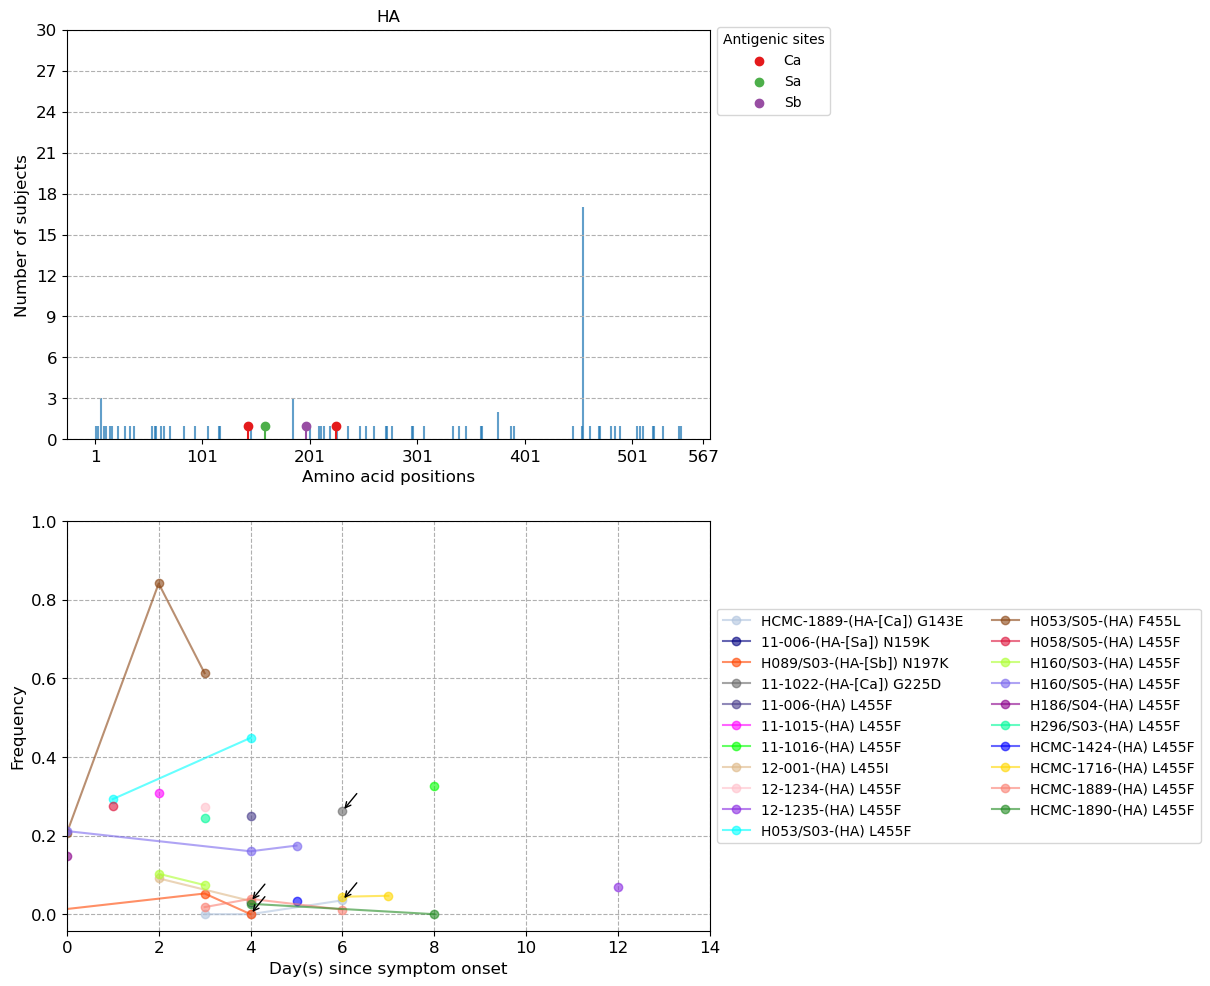

46 0.03614457831325301 [0.0246732  0.04767101]
48 0.06147332714234123 [0.03101457 0.10456112]


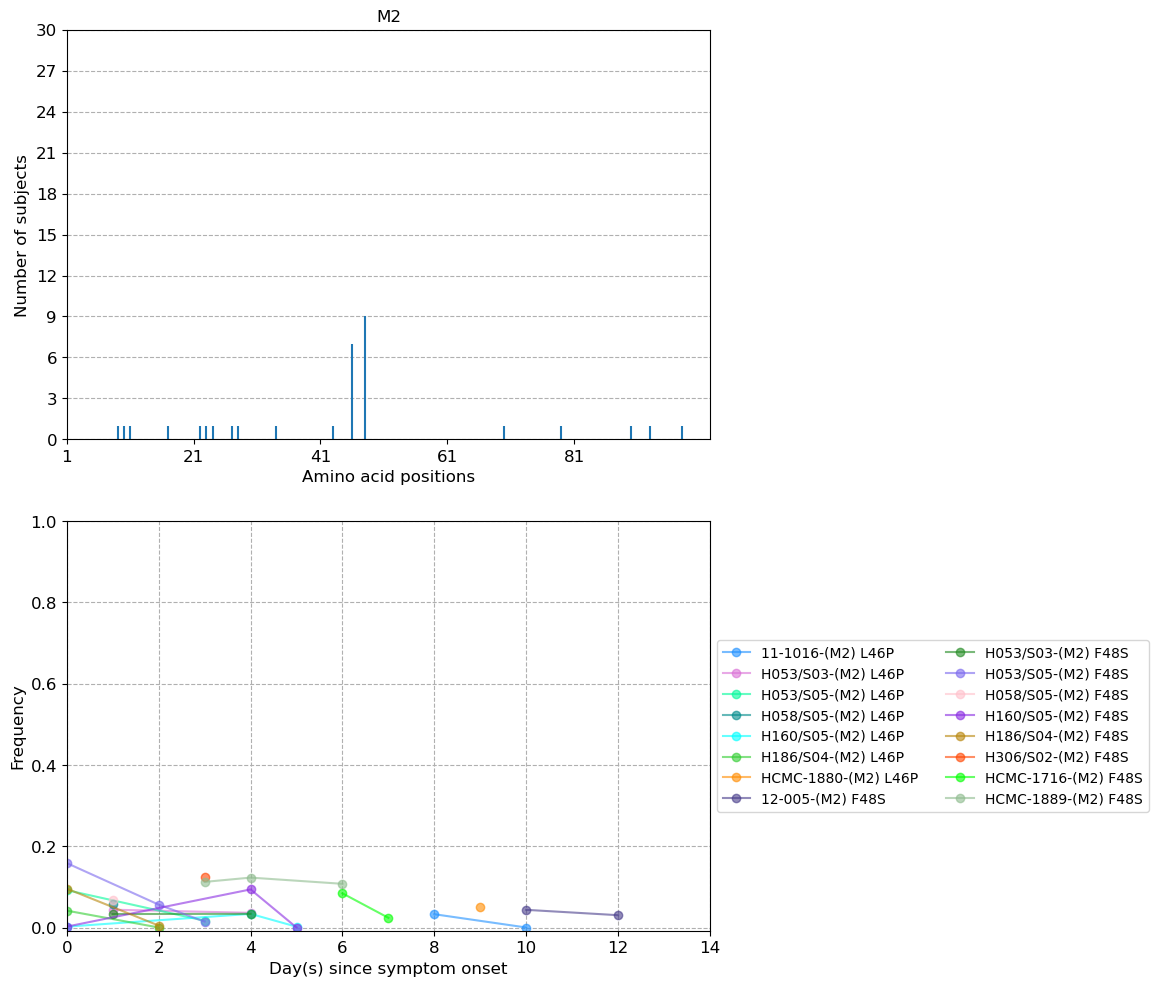

275 0.11366713764276462 [0.07145824 0.36513158]
{7: ['12-005'], 4: ['HCMC-1890']}


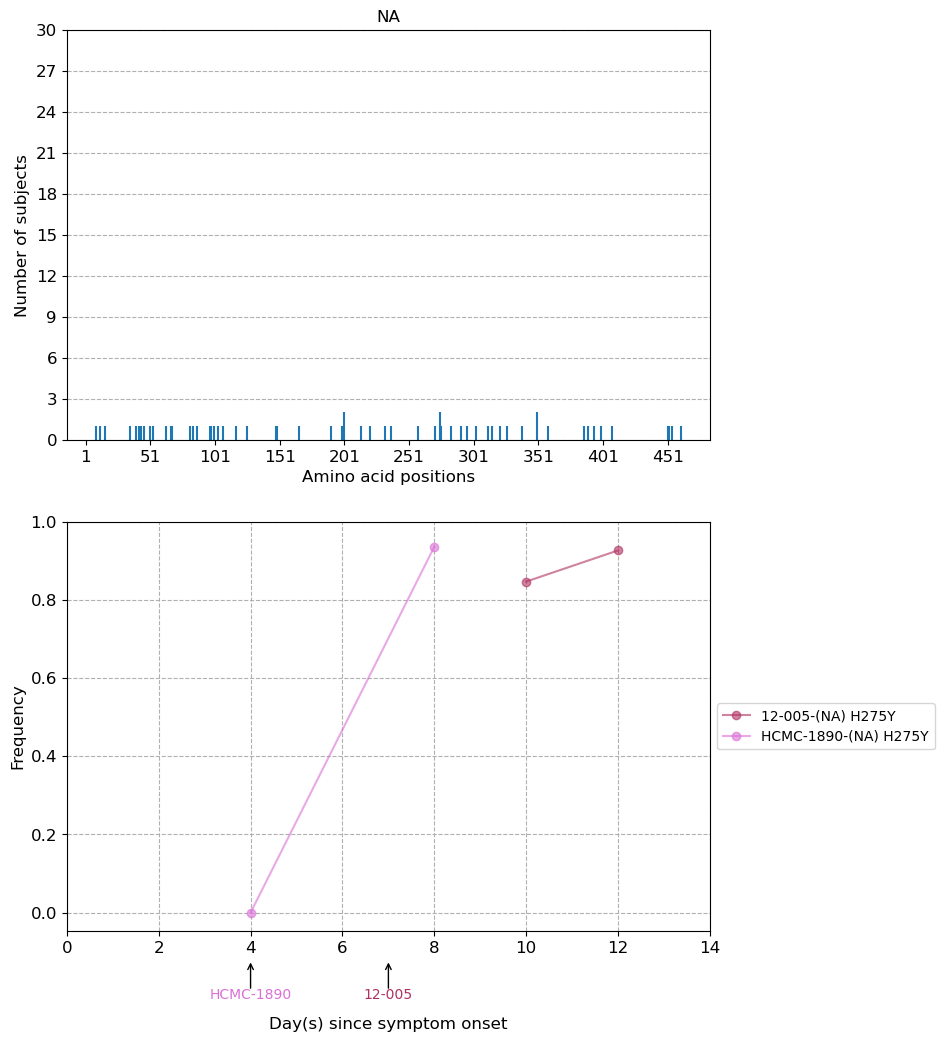

In [20]:
color_list = ["#696969","#556b2f","#8b4513","#228b22","#483d8b","#b8860b","#008b8b","#4682b4",
              "#000080","#32cd32","#8fbc8f","#8b008b","#b03060","#ff4500","#ff8c00","#ffd700",
              "#deb887","#00ff00","#00fa9a","#8a2be2","#dc143c","#00ffff","#0000ff","#adff2f",
              "#da70d6","#b0c4de","#ff00ff","#1e90ff","#fa8072","#ff1493","#7b68ee","#ffc0cb"]
ant_sites_colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]
ant_sites_df = ha_numbering_conversion[~pd.isna(ha_numbering_conversion[subtype_ant])]

filter_dict = {"HA":sorted(set(aa_substitution_trace[~pd.isna(aa_substitution_trace["HA_ant"])].index.get_level_values(2))) + [455], 
               "NA":[275, 292, 119, 329], "M2":[46, 48]}

NA_color = {}

for protein in sorted(set(aa_substitution_trace.index.get_level_values(1))): 
    
    if protein not in filter_dict.keys(): # limit to HA and M 
        continue
        
    # shuffle color list randomly 
    random.shuffle(color_list)
    
    protein_aa_substitution_trace = aa_substitution_trace.xs(protein, level=1)
    
    # proteinrate two panel plots
    # top panel - x-axis aa pos vs y-axis number of individuals; 
    # bottom panel - temporal changes 
    with plt.style.context("default"):
        fig, axes = plt.subplots(2, 1, figsize=(8.3, 11.7))
        top_x_values = []
        top_y_values = []

        colidx = 0 
        
        if protein == "NA": # for plotting oseltamivir start date 
            oseltamivir_consolidate = {}
            accounted_subject = []
        
        for aapos in sorted(set(protein_aa_substitution_trace.index.get_level_values(1))):
            aapos_freq = []
            
            aapos_protein_aa_substitution_trace = protein_aa_substitution_trace.xs(aapos, level=1)
            
            # skip if mutation only found in 1 subject for 1 timepoint 
            subject_list = list(set(aapos_protein_aa_substitution_trace.index.get_level_values(0)))

            # number of inidividuals and aa position 
            top_x_values.append(aapos)
            top_y_values.append(len(subject_list))

            for subject_id in sorted(subject_list): 
                
                if aapos not in filter_dict[protein]: # only plot trace for filtered positions
                    continue
                
                if protein == "NA": 
                    if subject_id not in accounted_subject: 
                        accounted_subject.append(subject_id)
                        if pd.isna(meta_df.loc[subject_id, "ost_days"]).all(): 
                            continue 
                        os_treatment_timepoint = list(set(meta_df.loc[subject_id, "ost_days"]))[0]
                        os_treatment_timepoint = sorted(map(int, os_treatment_timepoint.split(";")))
                        
                        try:
                            oseltamivir_consolidate[os_treatment_timepoint[0]].append(subject_id)
                        except:
                            oseltamivir_consolidate[os_treatment_timepoint[0]] = [subject_id]
                            
                subject_aapos_protein_aa_substitution_trace = aapos_protein_aa_substitution_trace.loc[subject_id]

                for aa_var in set(subject_aapos_protein_aa_substitution_trace.index): 
                    aa_var_subject_aapos_protein_aa_substitution_trace = subject_aapos_protein_aa_substitution_trace.loc[aa_var]
                    
                    try: 
                        btm_x_values = list(aa_var_subject_aapos_protein_aa_substitution_trace['timepoint'])
                    except: 
                        btm_x_values = [aa_var_subject_aapos_protein_aa_substitution_trace['timepoint']]
                        
                    try:
                        btm_y_values = list(aa_var_subject_aapos_protein_aa_substitution_trace['prop'])
                    except: 
                        btm_y_values = [aa_var_subject_aapos_protein_aa_substitution_trace['prop']]
                    
                    sorted_x_values = sorted(btm_x_values)
                    sorted_y_values = [btm_y_values[btm_x_values.index(x)] for x in sorted_x_values]
                    btm_x_values = sorted_x_values[:]
                    btm_y_values = sorted_y_values[:]
                    aapos_freq += sorted_y_values
                    
                    try: 
                        aa_consensus = aa_var_subject_aapos_protein_aa_substitution_trace['aa_consensus'].iloc[0]
                    except: 
                        aa_consensus = aa_var_subject_aapos_protein_aa_substitution_trace['aa_consensus']

                    label = '%s-(%s) %s%i%s'%(subject_id, protein, aa_consensus, aapos, aa_var)
                    if protein == 'HA' and aapos in list(ant_sites_df[HAnum_subtype]):
                        ant_site_type = ant_sites_df[ant_sites_df[HAnum_subtype]==aapos][subtype_ant].iloc[0]
                        label = '%s-(%s-[%s]) %s%i%s'%(subject_id, protein, ant_site_type, aa_consensus, aapos, aa_var)
                        
                        axes[1].annotate('', xy=(btm_x_values[-1], btm_y_values[-1]),
                                         xytext=(btm_x_values[-1]+0.35, btm_y_values[-1]+0.05),
                                         arrowprops=dict(arrowstyle='->',facecolor='k'), alpha=0.8)  
                        
                    # NA 292K starts off as majority variant in some sample 
                    if protein == "NA" and aapos == 275 and aa_var == "H" and aa_consensus == "Y": 
                        btm_y_values = 1-np.array(btm_y_values)
                        label = '%s-(%s) %s%i%s'%(subject_id, protein, aa_var, aapos, aa_consensus)
                        
                    axes[1].plot(btm_x_values, btm_y_values, "-o", 
                                 color=color_list[colidx], 
                                 label=label, alpha=0.6)
                    
                    # colour of NA annotation 
                    if protein == "NA": 
                        NA_color[subject_id] = color_list[colidx]
                        
                    colidx += 1
                    if colidx >= len(color_list): 
                        colidx = 0
            
            if len(aapos_freq) > 0:
                aapos_freq = np.array(aapos_freq)
                aapos_freq = aapos_freq[aapos_freq>0.]
                print (aapos, np.median(aapos_freq), np.percentile(aapos_freq, [25, 75]))
        
        # Oseltamivir treatment start day 
        if protein == "NA": 
            print (oseltamivir_consolidate)
            y_coords_xlabel = 0
            for x_pos, subject_list in oseltamivir_consolidate.items(): 
                ######### annotating oseltamivir start day  #########
                axes[1].annotate('', xy=(x_pos, -0.12),
                                 xytext=(x_pos, -0.2),
                                 arrowprops=dict(arrowstyle='->',facecolor='k'),  
                                 annotation_clip=False)  
                subject_list = set(subject_list)
                for sidx, subject_id in enumerate(subject_list):
                    axes[1].annotate(subject_id,
                                     xy=(x_pos, -0.21 - (sidx*0.04)),
                                     xytext=(x_pos, -0.21 - (sidx*0.04)),
                                     ha='center', va='center',
                                     annotation_clip=False, 
                                     color=NA_color[subject_id])
                    if -0.21 - (sidx*0.04) < y_coords_xlabel: 
                        y_coords_xlabel = -0.21 - (sidx*0.04)
            #raise Exception
        
        # plot number of individuals vs aa positions 
        if protein == "HA": 

            # non-antigenic sites 
            x_values = []
            y_values = []
            for xidx, x_val in enumerate(top_x_values): 
                if x_val not in list(ant_sites_df[HAnum_subtype]):
                    x_values.append(x_val)
                    y_values.append(top_y_values[xidx])
            axes[0].vlines(x_values, [0]*len(x_values), y_values, alpha=0.7, zorder=0)

            # antigenic sites
            for ast_idx, ant_site_type in enumerate(sorted(set(ant_sites_df[subtype_ant]))): 
                ant_sites = list(ant_sites_df[ant_sites_df[subtype_ant]==ant_site_type][HAnum_subtype])
                x_values = []
                y_values = []
                for xidx, x_val in enumerate(top_x_values): 
                    if x_val in ant_sites:
                        x_values.append(x_val)
                        y_values.append(top_y_values[xidx])

                if len(x_values) > 0:
                    axes[0].vlines(x_values, [0]*len(x_values), y_values, color=ant_sites_colors[ast_idx])
                    axes[0].scatter(x_values, y_values, color=ant_sites_colors[ast_idx], label=ant_site_type)

        else:        
            axes[0].vlines(top_x_values, [0]*len(top_x_values), top_y_values)

        # set x ticks for top panel
        # amino acid sequence length < 100
        if max(gene_to_proteinorf.xs(protein, level=2)['aa']) <= 100: 
            sbin = 20
        # < 500aa 
        elif max(gene_to_proteinorf.xs(protein, level=2)['aa']) <= 500:
            sbin = 50
        else: 
            sbin = 100

        xticks = list(map(int, (np.arange(min(gene_to_proteinorf.xs(protein, level=2)['aa']), max(gene_to_proteinorf.xs(protein, level=2)['aa']), sbin))))
        if int(max(gene_to_proteinorf.xs(protein, level=2)['aa'])) - xticks[-1] > 20: 
            xticks.append(int(max(gene_to_proteinorf.xs(protein, level=2)['aa'])))
        axes[0].set_xticks(sorted(set(xticks)))
        axes[0].set_xlabel('Amino acid positions', fontsize=12)

        # set y ticks for top panel 
        axes[0].set_yticks(np.linspace(0, 30, 11)) 
        axes[0].set_ylim((0, 30))
        axes[0].set_ylabel('Number of subjects', fontsize=12)

        # set title on top panel
        axes[0].set_title(protein)

        # set legend for HA and lower panel 
        if protein == 'HA':
            axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.9), fontsize=10, title="Antigenic sites")
        axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, ncol=1 if protein == "NA" else 2)

        # set lower panel x and y ticks
        axes[1].set_yticks(np.linspace(0, 1., 6))
        axes[1].set_ylabel('Frequency', fontsize=12)

        axes[1].set_xticks(range(0, 15, 2))
        axes[1].set_xlim((0, 14))
        axes[1].set_xlabel('Day(s) since symptom onset', fontsize=12)
        if protein == "NA":
            axes[1].xaxis.set_label_coords(0.5, y_coords_xlabel)

        # x grid lines for lower panel only 
        axes[1].grid(zorder=0, ls='--', axis='x')

        for ax in axes: 
            # grid lines 
            ax.grid(zorder=0, ls='--', axis='y')
            ax.set_axisbelow(True)

            # tick fontsize
            ax.tick_params(axis='both', which='major', labelsize=12)

        plt.savefig('./results/figures/protein_mutation_freqplot_%s.pdf'%(protein), bbox_inches='tight', pad_inches=0.05)
        plt.show()
    

# Within host evolutionary rate (Xue et al. 2020)

$r = \frac{\sum_{i}^{n}f_i}{nt}$ where $f_i$ is the total frequency of within-host mutations for site $i$, $n$ is the number of available sites and $t$ is the time (days) since start of infection (symptom onset). 

In [21]:
try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 
variant_call_df = variant_call_df.set_index('sampid')

try: 
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index(['subject_id', 'timepoint'])

# for each subject 
all_r = []
for subject_id in sorted(set(meta_df.index.get_level_values(0))): 
        
    subject_meta_df = meta_df.loc[subject_id].copy()
    
    # only analyse individuals where we have info on time since symptom onset  
    if pd.isna(subject_meta_df.index).any(): 
        continue
    
    # genome must satisfy min breadth 
    subject_meta_df = subject_meta_df[(subject_meta_df[sorted_refnames]>min_breadth).all(axis=1)]
    
    if len(subject_meta_df) == 0: 
        continue

    subject_r = []
    #print (subject_id)
    for timepoint in sorted(set(subject_meta_df.index)):
        #print (timepoint)
        if pd.isna(timepoint): 
            continue
            
        try:
            sample_vcf = variant_call_df.loc[subject_meta_df.loc[timepoint, 'sampid']].copy()
            sample_vcf = sample_vcf[~pd.isna(sample_vcf['nonsyn'])] # disregard nnucpos if we don't whether it will lead to syn or nonsyn sub
            sample_vcf = sample_vcf[sample_vcf['nuc_prop']>=0.02] # at least 2% variants 
            sample_vcf = sample_vcf.set_index(['gene', 'nucpos'])
        except: 
            # no mutations 
            continue
        
        # differentiate between syn and nonsyn mutations 
        mutation_frequencies = {}
        
        for gene in sorted_refnames: 
            
            try: 
                sample_vcf.loc[gene]
            except: 
                continue 
                
            for nucpos in set(sample_vcf.loc[gene].index):

                nucpos_sample_vcf =  sample_vcf.loc[(gene, nucpos)]

                if isinstance(nucpos_sample_vcf, pd.DataFrame):
                    # if all mutations are either nonsyn or syn for all proteins  
                    nonsyn_set = list(set(nucpos_sample_vcf['nonsyn']))
                    if len(nonsyn_set) == 1:  
                        nonsyn_bool = nonsyn_set[0]
                        # sum over all nucleotide variants for site freq 
                        site_freq = nucpos_sample_vcf.drop_duplicates('nuc_var')['nuc_prop'].sum()
                        try: 
                            mutation_frequencies[gene][nonsyn_bool].append(site_freq)
                        except: 
                            try: 
                                mutation_frequencies[gene][nonsyn_bool] = [site_freq]
                            except: 
                                mutation_frequencies[gene] = {nonsyn_bool:[site_freq]}
                    else:
                        for protein in set(nucpos_sample_vcf['protein']):
                            # for each protein encoded 
                            protein_nucpos_sample_vcf = nucpos_sample_vcf[nucpos_sample_vcf['protein']==protein]
                            
                            protein_nonsyn_set = list(set(protein_nucpos_sample_vcf['nonsyn']))
                            # if all mutations are either nonsyn or syn in specific protein 
                            if len(protein_nonsyn_set) == 1: 
                                protein_nonsyn_bool = protein_nonsyn_set[0]
                                # sum over all nucleotide variants for site freq 
                                site_freq = protein_nucpos_sample_vcf.drop_duplicates('nuc_var')['nuc_prop'].sum()
                                try: 
                                    mutation_frequencies[gene][nonsyn_bool].append(site_freq)
                                except: 
                                    try: 
                                        mutation_frequencies[gene][nonsyn_bool] = [site_freq]
                                    except: 
                                        mutation_frequencies[gene] = {nonsyn_bool:[site_freq]}
                            else:
                                # syn AND nonsyn mutations in protein
                                # requires aa_coverage > min_cov to use aa_prop 
                                if protein_nucpos_sample_vcf['aa_coverage'].iloc[0] < min_cov: 
                                    display (protein_nucpos_sample_vcf)
                                    raise Exception('BOOBOOBAHBAH')
                                else: 
                                    for protein_nonsyn_bool in protein_nonsyn_set:  
                                        # sum over all nucleotide variants for site freq 
                                        site_freq = protein_nucpos_sample_vcf[protein_nucpos_sample_vcf['nonsyn']==protein_nonsyn_bool].drop_duplicates('nuc_var')['aa_prop'].sum()
                                        try: 
                                            mutation_frequencies[gene][nonsyn_bool].append(site_freq)
                                        except: 
                                            try: 
                                                mutation_frequencies[gene][nonsyn_bool] = [site_freq]
                                            except: 
                                                mutation_frequencies[gene] = {nonsyn_bool:[site_freq]}
                                                
                else:
                    # one nucleotide resulting in one protein mutation 
                    nonsyn_bool = nucpos_sample_vcf['nonsyn']
                    site_freq = nucpos_sample_vcf['nuc_prop']
                    try: 
                        mutation_frequencies[gene][nonsyn_bool].append(site_freq)
                    except: 
                        try: 
                            mutation_frequencies[gene][nonsyn_bool] = [site_freq]
                        except: 
                            mutation_frequencies[gene] = {nonsyn_bool:[site_freq]}

        # compute r for curr timepoint
        for gene in sorted_refnames:
            try: 
                nsbool_to_sitefreq = mutation_frequencies[gene]
            except: 
                subject_r.append({'Gene':gene, 'nonsyn':0, 'r':0.,
                                  'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
                subject_r.append({'Gene':gene, 'nonsyn':1, 'r':0.,
                                  'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
                subject_r.append({'Gene':gene, 'nonsyn':-1, 'r':0.,
                                  'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
                continue 
            
            for nonsyn_bool in range(-1, 2): 
                try: 
                    site_freq_list = nsbool_to_sitefreq[nonsyn_bool]
                except: 
                    subject_r.append({'Gene':gene, 'nonsyn':nonsyn_bool, 'r':0.,
                                      'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
                    continue 
                    
                r = np.sum(site_freq_list)/influenza_gene_len[gene]/(timepoint+1)

                subject_r.append({'Gene':gene, 'nonsyn':nonsyn_bool, 'r':r, 
                                  'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
                
    all_r.append(pd.DataFrame.from_dict(subject_r))

all_r = pd.concat(all_r, ignore_index=True)
all_r = all_r.set_index('nonsyn')

all_r.loc[0]

,Gene,r,Patient,Day(s) since symptom onset
nonsyn,,,,
0,1-PB2,0.000015,11-001,2
0,2-PB1,0.000080,11-001,2
0,3-PA,0.000073,11-001,2
0,4-HA,0.000007,11-001,2
0,5-NP,0.000038,11-001,2
...,...,...,...,...
0,4-HA,0.000014,HCMC-1890,4
0,5-NP,0.000000,HCMC-1890,4
0,6-NA,0.000000,HCMC-1890,4


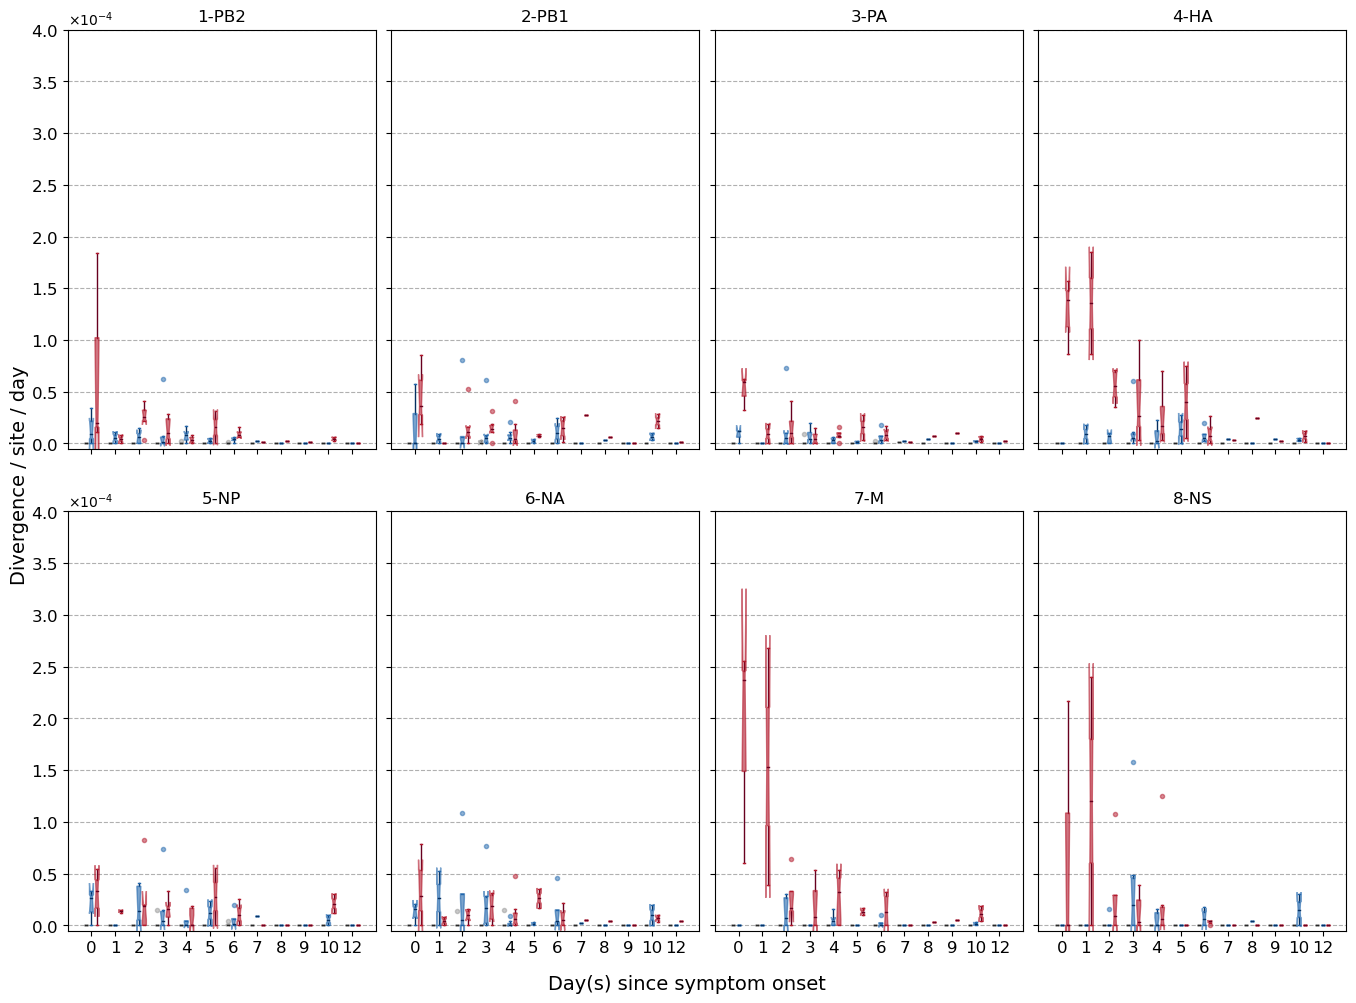

In [22]:
from scipy.stats import wilcoxon

with plt.style.context('default'):
    fig, axes = plt.subplots(2, 4, figsize=(16.5, 11.7), sharex=True, sharey=True)
    color_dict = {0.:{'face':'#2166ac', 'faintline':'#2166ac', 'strongline':'#053061'}, 
                  1.:{'face':'#b2182b', 'faintline':'#b2182b', 'strongline':'#67001f'}, 
                  -1.:{'face':'#969696', 'faintline':'#969696', 'strongline':'#252525'}}

    annotate_pvalues = {}
    x_variable = 'Day(s) since symptom onset'
    for gidx, gene in enumerate(sorted_refnames):
        if gidx < 4: 
            plot_row = 0
        else: 
            plot_row = 1
        plot_col = gidx%4
        
        ax = axes[(plot_row, plot_col)]
        y_max = -1

        syn_and_nonsyn_rate_dist = {}
        for nonsyn in sorted(set(all_r.index.get_level_values(0))):
            sns_all_r = all_r.loc[nonsyn].copy()

            sns_all_r = sns_all_r.set_index([x_variable, 'Patient', 'Gene']).sort_index()
            sns_all_r = sns_all_r.xs(gene, level=2)
            
            # start from day 2 onwards
            x_values = sorted(set(sns_all_r.index.get_level_values(0)))#[:-2]

            r_list = []
            for _x, x_val in enumerate(x_values):
                if isinstance(sns_all_r.loc[x_val, 'r'], pd.Series): 
                    r_list.append(list(sns_all_r.loc[x_val, 'r']))
                else: 
                    r_list.append([sns_all_r.loc[x_val, 'r']])
                    
            syn_and_nonsyn_rate_dist[nonsyn] = r_list

            if nonsyn > 0: 
                shift = .7
            elif nonsyn < 0:
                shift = -.7
            else:
                shift = 0.

            c = color_dict[nonsyn]
            x_positions = np.arange(0, 3*len(x_values), 3)
            bp = ax.boxplot(r_list, positions=x_positions+shift, notch=True,
                       patch_artist=True,
                       boxprops=dict(facecolor=c['face'], color=c['faintline'], alpha=0.6),
                       capprops=dict(color=c['faintline']),
                       whiskerprops=dict(color=c['strongline']),
                       flierprops=dict(markeredgecolor=c['face'], markerfacecolor=c['face'], marker='.', alpha=0.5),
                       medianprops=dict(color=c['strongline']),)

            max_whisker = max([item.get_ydata()[1] for item in bp['whiskers']])
            if max_whisker > y_max: 
                y_max = max_whisker

        # create dataframe of rates
        rate_df = []
        for idx, (r_list1, r_list2) in enumerate(zip(syn_and_nonsyn_rate_dist[0], syn_and_nonsyn_rate_dist[1])):
            r_list3 = syn_and_nonsyn_rate_dist[-1][idx] # stop
            
            med1 = np.median(r_list1)
            med2 = np.median(r_list2)
            med3 = np.median(r_list3)
            
            """if len(r_list1) > 2: 
                try: 
                    pval = wilcoxon(r_list1, r_list2, mode="auto").pvalue # perform wilcoxon signed-rank test between syn and nonsyn
                except: 
                    pval = None
            else:""" 
            pval = None
            rate_df.append({x_variable:x_values[idx], "gene":gene, 'med_syn':med1, 'mad_syn':np.median([abs(r-med1) for r in r_list1]),
                            'min_syn':np.min(r_list1), 'max_syn':np.max(r_list1),
                            'med_nonsyn':med2, 'mad_nonsyn':np.median([abs(r-med2) for r in r_list2]),
                            'min_nonsyn':np.min(r_list2), 'max_nonsyn':np.max(r_list2),
                            'pvalue':pval, 
                            'med_stop':med3, "mad_stop":np.median([abs(r-med3) for r in r_list3]), 
                            "min_stop":np.min(r_list3), "max_stop":np.max(r_list3)})
            
            if pval != None and pval < 0.05: 
                try: 
                    annotate_pvalues[(plot_row, plot_col)].append((x_positions[idx], pval, y_max))
                except: 
                    annotate_pvalues[(plot_row, plot_col)] = [(x_positions[idx], pval, y_max)]

        rate_df = pd.DataFrame.from_dict(rate_df)
        rate_df.to_csv('./results/rate_gene_df_%s.csv'%(x_variable), index=False)
        #display(rate_df)

        # set ylabel, lim, ticks and scale
        ax.set_ylim((-.5e-5, 4e-4))
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,10), useMathText=True)

        # set xlabel, lim, ticks and scale
        ax.set_xlim((-3., 3*len(x_values)))
        ax.set_xticks(np.arange(0, 3*len(x_values), 3))
        ax.set_xticklabels(x_values)
        
        ax.set_title(gene)
        
        # change tick size 
        ax.tick_params(axis='both', which='major', labelsize=12)

        # grid lines 
        ax.grid(axis='y', ls='--', zorder=0)
        ax.set_axisbelow(True)
        
        if plot_row == 1:
            # get a tick and will position things next to the last one
            ticklab = ax.xaxis.get_ticklabels()[0]
            trans = ticklab.get_transform()
            ax.xaxis.set_label_coords(16, -0.15, transform=trans)

    for (plot_row, plot_col) in annotate_pvalues.keys(): 
        ax = axes[(plot_row, plot_col)]
        for (x_pos, pval, y_max) in annotate_pvalues[(plot_row, plot_col)]:
            if plot_row == 1: 
                y_pos = -.3e-4
            else: 
                y_pos = -.2e-4
            ######### annotating the x axis   #########
            ax.annotate('', xy=(x_pos-1., y_pos),
                        xytext=(x_pos+1., y_pos),
                        arrowprops=dict(arrowstyle='-',facecolor='red'),          
                        annotation_clip=False)  
            
            ax.annotate("*",
                        xy=(x_pos-1., y_pos-.1e-4),
                        xytext=(x_pos, y_pos-.1e-4),
                        ha='center', va='center',
                        annotation_clip=False)

    fig.subplots_adjust(hspace=0.3)

    # y-axis label 
    fig.text(0.09, 0.5, 'Divergence / site / day', va='center', 
             fontsize=14, rotation=90)
    # x-axis label
    fig.text(0.5, 0.06, re.sub("symptom", "symptom", x_variable), ha='center', 
             fontsize=14)

    """# legend 
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Synonymous',
                              markerfacecolor='#2b83ba', markersize=12), 
                       Line2D([0], [0], marker='o', color='w', label='Nonsynonymous',
                              markerfacecolor='#d7191c', markersize=12)]
    #fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.93, 0.45), fontsize=10)"""
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    plt.savefig('./results/figures/evolutionary_rate_gene.pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()


-1 1-PB2


Patient  Day(s) since symptom onset
11-001   2                             0.0
11-002   4                             0.0
11-006   4                             0.0
11-1015  2                             0.0
11-1016  8                             0.0
Name: r, dtype: float64

0 1-PB2


Patient  Day(s) since symptom onset
11-001   2                             0.000015
11-002   4                             0.000006
11-006   4                             0.000000
11-1015  2                             0.000000
11-1016  8                             0.000000
Name: r, dtype: float64

1 1-PB2


Patient  Day(s) since symptom onset
11-001   2                             0.000041
11-002   4                             0.000008
11-006   4                             0.000000
11-1015  2                             0.000022
11-1016  8                             0.000003
Name: r, dtype: float64

,Gene,med_syn,iqr_syn_1,iqr_syn_3,min_syn,max_syn,med_nonsyn,iqr_nonsyn_1,iqr_nonsyn_3,min_nonsyn,max_nonsyn,pvalue,med_stop,iqr_stop_1,iqr_stopn_3,min_stop,max_stop
0,1-PB2,0.000002,0.0,0.000009,0.0,0.000062,0.000006,0.000002,0.000018,0.0,0.000184,0.031113,0.0,0.0,0.0,0.0,0.000002
1,2-PB1,0.000004,0.0,0.000009,0.0,0.000080,0.000011,0.000003,0.000020,0.0,0.000086,0.092394,0.0,0.0,0.0,0.0,0.000004
2,3-PA,0.000003,0.0,0.000005,0.0,0.000073,0.000007,0.000003,0.000015,0.0,0.000062,0.008849,0.0,0.0,0.0,0.0,0.000010
3,4-HA,0.000004,0.0,0.000009,0.0,0.000061,0.000026,0.000007,0.000070,0.0,0.000185,0.000027,0.0,0.0,0.0,0.0,0.000000
4,5-NP,0.000000,0.0,0.000014,0.0,0.000074,0.000012,0.000000,0.000019,0.0,0.000083,0.065112,0.0,0.0,0.0,0.0,0.000015
5,6-NA,0.000002,0.0,0.000017,0.0,0.000108,0.000008,0.000002,0.000017,0.0,0.000078,0.228880,0.0,0.0,0.0,0.0,0.000015
6,7-M,0.000000,0.0,0.000002,0.0,0.000030,0.000016,0.000000,0.000040,0.0,0.000268,0.000099,0.0,0.0,0.0,0.0,0.000000
7,8-NS,0.000000,0.0,0.000012,0.0,0.000158,0.000000,0.000000,0.000012,0.0,0.000240,0.444509,0.0,0.0,0.0,0.0,0.000000


/Users/alvin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alvin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Day(s) since symptom onset,med_syn,iqr_syn_1,iqr_syn_3,min_syn,max_syn,med_nonsyn,iqr_nonsyn_1,iqr_nonsyn_3,min_nonsyn,max_nonsyn,pvalue,med_stop,iqr_stop_1,iqr_stopn_3,min_stop,max_stop
0,0,1.101498e-05,9.983297e-06,1.151732e-05,8.951616e-06,1.201966e-05,0.000068,0.000055,0.000085,0.000042,0.000103,0.250000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,5.810989e-06,5.052764e-06,6.569213e-06,4.294540e-06,7.327437e-06,0.000041,0.000038,0.000044,0.000035,0.000047,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2,1.383047e-05,6.504522e-06,1.432462e-05,0.000000e+00,3.598134e-05,0.000024,0.000021,0.000026,0.000011,0.000041,0.062500,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.495608e-06
3,3,8.734345e-06,5.847585e-06,1.857240e-05,6.296367e-07,4.157518e-05,0.000017,0.000009,0.000025,0.000005,0.000027,0.562500,0.000000e+00,0.000000e+00,4.461566e-07,0.000000e+00,3.919003e-06
4,4,4.652698e-06,3.239962e-06,6.945231e-06,2.904809e-06,1.012020e-05,0.000012,0.000006,0.000019,0.000002,0.000025,0.078125,0.000000e+00,0.000000e+00,1.987696e-07,0.000000e+00,1.598085e-06
5,5,4.307885e-06,2.870722e-06,5.745047e-06,1.433560e-06,7.182210e-06,0.000019,0.000013,0.000025,0.000007,0.000031,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,6,7.533583e-06,4.679519e-06,1.019413e-05,2.382185e-06,1.191090e-05,0.000010,0.000008,0.000012,0.000007,0.000014,0.625000,2.175545e-07,0.000000e+00,4.837414e-07,0.000000e+00,6.296386e-07
7,7,2.544685e-06,2.544685e-06,2.544685e-06,2.544685e-06,2.544685e-06,0.000006,0.000006,0.000006,0.000006,0.000006,1.000000,2.662380e-07,2.662380e-07,2.662380e-07,2.662380e-07,2.662380e-07
8,8,1.531131e-06,1.531131e-06,1.531131e-06,1.531131e-06,1.531131e-06,0.000007,0.000007,0.000007,0.000007,0.000007,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,9,5.028116e-07,5.028116e-07,5.028116e-07,5.028116e-07,5.028116e-07,0.000003,0.000003,0.000003,0.000003,0.000003,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


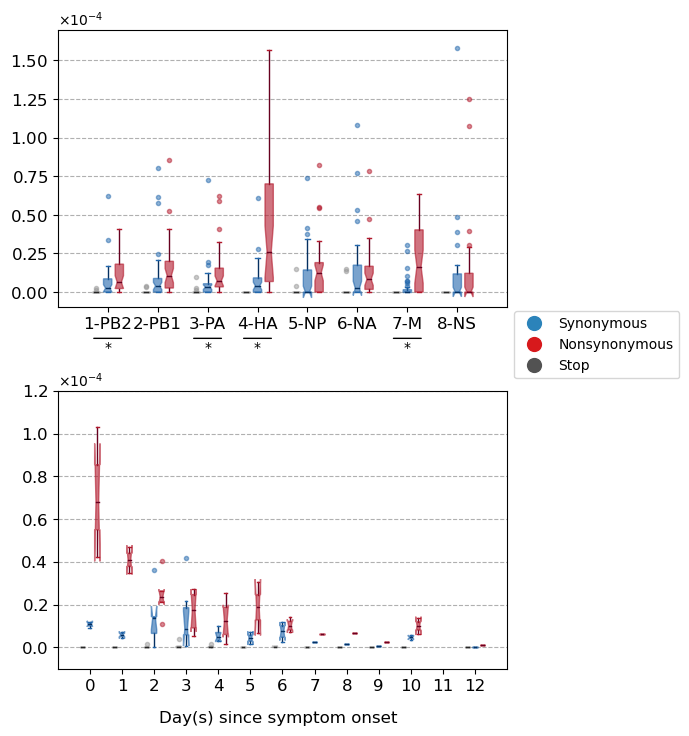

In [29]:
with plt.style.context("default"):
    fig, axes = plt.subplots(2, 1, figsize=(5.8, 8.3))
    color_dict = {0.:{'face':'#2166ac', 'faintline':'#2166ac', 'strongline':'#053061'}, 
                  1.:{'face':'#b2182b', 'faintline':'#b2182b', 'strongline':'#67001f'},
                  -1.:{'face':'#969696', 'faintline':'#969696', 'strongline':'#252525'}}

    annotate_pvalues = {}
    y_max = -1
    for plot_row, x_variable in enumerate(['Gene', 'Day(s) since symptom onset']):

        ax = axes[plot_row]

        syn_and_nonsyn_rate_dist = {}
        for nonsyn in sorted(set(all_r.index.get_level_values(0))):
            sns_all_r = all_r.loc[nonsyn].copy()

            # set x axis variable 
            if x_variable == 'Gene':
                sns_all_r = sns_all_r.set_index([x_variable, 'Patient', 'Day(s) since symptom onset']).sort_index()
            else: 
                sns_all_r = sns_all_r.set_index([x_variable, 'Patient']).sort_index()
            
            if plot_row == 0:
                x_values = sorted(set(sns_all_r.index.get_level_values(0)))
            else: 
                # skip day 1 - only two samples for D1 since symptom onset
                x_values = sorted(set(sns_all_r.index.get_level_values(0)))
            x_positions = np.arange(0, 3*len(x_values), 3)

            r_list = []
            X = []
            for _x, x_val in enumerate(x_values):
                if plot_row == 1: 
                    if _x > 0 and x_val - prev_x > 1: 
                        for dummyx in range(int(prev_x)+1, int(x_val)): 
                            r_list.append([])
                            X.append(dummyx)
                    
                    day_sns_all_r = sns_all_r.loc[x_val]
                    day_r = []
                    for subject_id in set(day_sns_all_r.index):
                        genome_r = (day_sns_all_r.loc[subject_id]['r'].to_numpy()*np.array([influenza_gene_len[gene] for gene in sorted_refnames])).sum()/sum(influenza_gene_len.values())
                        day_r.append(genome_r)
                        #day_r += list(day_sns_all_r.loc[subject_id]['r'])
                    
                    r_list.append(day_r)
                    X.append(x_val)
                    prev_x = x_val
                    
                else: 
                    if isinstance(sns_all_r.loc[x_val, 'r'], pd.Series): 
                        r_list.append(list(sns_all_r.loc[x_val, 'r']))

                        if _x == 0: 
                            print (nonsyn, x_val)
                            display (sns_all_r.loc[x_val, 'r'].head())
                    else: 
                        r_list.append([sns_all_r.loc[x_val, 'r']])
                    X.append(x_val)
                    
            syn_and_nonsyn_rate_dist[nonsyn] = r_list

            if nonsyn < 0: 
                shift = -.7
            elif nonsyn > 0: 
                shift = .7
            else: 
                shift = 0.

            c = color_dict[nonsyn]
            bp = ax.boxplot(r_list, positions=np.arange(0, 3*len(X), 3)+shift, notch=True,
                            patch_artist=True,
                            boxprops=dict(facecolor=c['face'], color=c['faintline'], alpha=0.6),
                            capprops=dict(color=c['faintline']),
                            whiskerprops=dict(color=c['strongline']),
                            flierprops=dict(markeredgecolor=c['face'], markerfacecolor=c['face'], marker='.', alpha=0.5),
                            medianprops=dict(color=c['strongline']),)

            max_whisker = max([item.get_ydata()[1] for item in bp['whiskers']])
            if max_whisker > y_max: 
                y_max = max_whisker

        # create dataframe of rates
        rate_df = []
        for idx, (r_list1, r_list2) in enumerate(zip(syn_and_nonsyn_rate_dist[0], syn_and_nonsyn_rate_dist[1])):
            r_list3 = syn_and_nonsyn_rate_dist[-1][idx] # stop
            
            med1 = np.median(r_list1)
            med2 = np.median(r_list2)
            med3 = np.median(r_list3)
            if len(r_list1) == 0 or len(r_list2) == 0: 
                pval = None
            else: 
                pval = wilcoxon(r_list1, r_list2).pvalue
                rate_df.append({x_variable:X[idx], 'med_syn':med1, 'iqr_syn_1':np.quantile(r_list1, 0.25), 'iqr_syn_3':np.quantile(r_list1, 0.75),
                            'min_syn':np.min(r_list1), 'max_syn':np.max(r_list1),
                            'med_nonsyn':med2, 'iqr_nonsyn_1':np.quantile(r_list2, 0.25), 'iqr_nonsyn_3':np.quantile(r_list2, 0.75), 
                            'min_nonsyn':np.min(r_list2), 'max_nonsyn':np.max(r_list2),
                            'pvalue':pval, 
                            'med_stop':med3, 'iqr_stop_1':np.quantile(r_list3, 0.25), 'iqr_stopn_3':np.quantile(r_list3, 0.75), 
                            "min_stop":np.min(r_list3), "max_stop":np.max(r_list3)})
            
            if pval != None and pval < 0.05: 
                try: 
                    annotate_pvalues[plot_row].append((x_positions[idx], pval))
                except: 
                    annotate_pvalues[plot_row] = [(x_positions[idx], pval)]

        rate_df = pd.DataFrame.from_dict(rate_df)
        rate_df.to_csv('./results/rate_df_%s.csv'%(x_variable), index=False)
        display(rate_df)

        # set ylabel, lim, ticks and scale
        if plot_row == 0: 
            ymax = 1.7e-4
        else: 
            ymax = 1.2e-4
        ax.set_ylim((-.1e-4, ymax))
        #ax.set_yticks(np.arange(0, ymax+.5e-4, .5e-4))
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,10), useMathText=True)

        # set xlabel, lim, ticks and scale
        ax.set_xlim((-3., 3*len(X)))
        ax.set_xticks(np.arange(0, 3*len(X), 3))
        ax.set_xticklabels(X)
        
        if plot_row == 1:
            # get a tick and will position things next to the last one
            ticklab = ax.xaxis.get_ticklabels()[0]
            trans = ticklab.get_transform()
            ax.xaxis.set_label_coords(8, -0.15, transform=trans)
            #ax.set_xlabel(x_variable, fontsize=12)

        # change tick size 
        ax.tick_params(axis='both', which='major', labelsize=12)

        # grid lines 
        ax.grid(axis='y', ls='--', zorder=0)
        ax.set_axisbelow(True)

    fig.subplots_adjust(hspace=0.3)

    for plot_idx in annotate_pvalues.keys(): 
        ax = axes[plot_idx]
        #print (annotate_pvalues[plot_idx])
        for (x_pos, pval) in annotate_pvalues[plot_idx]:
            if plot_idx == 1: 
                y_pos = -.3e-4
            else: 
                y_pos = -.3e-4
            ######### annotating the x axis   #########
            ax.annotate('', xy=(x_pos-1., y_pos),
                        xytext=(x_pos+1., y_pos),
                        arrowprops=dict(arrowstyle='-',facecolor='red'),          
                        annotation_clip=False)  
            
            ax.annotate("*",
                        xy=(x_pos-1., y_pos-.06e-4),
                        xytext=(x_pos, y_pos-.06e-4),
                        ha='center', va='center',
                        annotation_clip=False)

    # y-axis label 
    #fig.text(0., 0.5, 'Divergence / site / day', va='center', fontsize=label_size, rotation=90)
    fig.text(0.3, 0.05, 'Day(s) since symptom onset', va='center', fontsize=label_size)
    # legend 
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Synonymous',
                              markerfacecolor='#2b83ba', markersize=12), 
                       Line2D([0], [0], marker='o', color='w', label='Nonsynonymous',
                              markerfacecolor='#d7191c', markersize=12), 
                       Line2D([0], [0], marker='o', color='w', label='Stop',
                              markerfacecolor='#525252', markersize=12)]

    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.9, 0.5), fontsize=10)
    
    plt.savefig('./results/figures/evolutionary_rate.pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()

In [24]:
print (min(rate_df["iqr_stop_1"]), max(rate_df["iqr_stopn_3"]))
display (rate_df)
print (min(rate_df["med_stop"]), max(rate_df["med_stop"]))

0.0 4.837413551565951e-07


,Day(s) since symptom onset,med_syn,iqr_syn_1,iqr_syn_3,min_syn,max_syn,med_nonsyn,iqr_nonsyn_1,iqr_nonsyn_3,min_nonsyn,max_nonsyn,pvalue,med_stop,iqr_stop_1,iqr_stopn_3,min_stop,max_stop
0,0,1.101498e-05,9.983297e-06,1.151732e-05,8.951616e-06,1.201966e-05,0.000068,0.000055,0.000085,0.000042,0.000103,0.250000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,5.810989e-06,5.052764e-06,6.569213e-06,4.294540e-06,7.327437e-06,0.000041,0.000038,0.000044,0.000035,0.000047,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2,1.383047e-05,6.504522e-06,1.432462e-05,0.000000e+00,3.598134e-05,0.000024,0.000021,0.000026,0.000011,0.000041,0.062500,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.495608e-06
3,3,8.734345e-06,5.847585e-06,1.857240e-05,6.296367e-07,4.157518e-05,0.000017,0.000009,0.000025,0.000005,0.000027,0.562500,0.000000e+00,0.000000e+00,4.461566e-07,0.000000e+00,3.919003e-06
4,4,4.652698e-06,3.239962e-06,6.945231e-06,2.904809e-06,1.012020e-05,0.000012,0.000006,0.000019,0.000002,0.000025,0.078125,0.000000e+00,0.000000e+00,1.987696e-07,0.000000e+00,1.598085e-06
5,5,4.307885e-06,2.870722e-06,5.745047e-06,1.433560e-06,7.182210e-06,0.000019,0.000013,0.000025,0.000007,0.000031,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,6,7.533583e-06,4.679519e-06,1.019413e-05,2.382185e-06,1.191090e-05,0.000010,0.000008,0.000012,0.000007,0.000014,0.625000,2.175545e-07,0.000000e+00,4.837414e-07,0.000000e+00,6.296386e-07
7,7,2.544685e-06,2.544685e-06,2.544685e-06,2.544685e-06,2.544685e-06,0.000006,0.000006,0.000006,0.000006,0.000006,1.000000,2.662380e-07,2.662380e-07,2.662380e-07,2.662380e-07,2.662380e-07
8,8,1.531131e-06,1.531131e-06,1.531131e-06,1.531131e-06,1.531131e-06,0.000007,0.000007,0.000007,0.000007,0.000007,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,9,5.028116e-07,5.028116e-07,5.028116e-07,5.028116e-07,5.028116e-07,0.000003,0.000003,0.000003,0.000003,0.000003,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


0.0 2.66237988007576e-07
